In [201]:
library(rstanarm)
library(ggformula)
library(tibble)
library(glue)
library(dplyr)
library(stringr)

In [202]:
# Set the maximum number of columns and rows to display
options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)
# Set the default plot size
options(repr.plot.width=18, repr.plot.height=12)

In [203]:
download_if_missing <- function(filename, url) {
    if (!file.exists(filename)) {
        dir.create(dirname(filename), showWarnings=FALSE, recursive=TRUE)
        download.file(url, destfile = filename, method="curl")
    }
}

# Regression predictors
In the election forecasting example of Section 7.1, we used inflation-adjusted growth in average personal income as a predictor.
From the standpoint of economics, it makes sense to adjust for inflation here.
But suppose the model had used growth in average personal income, not adjusting for inflation.
How would this have changed the resulting regression?
How would this have affected the fit and interpretation of the results?

## Answer

Inflation roughly adds an extra few percentage points (say 2-3%) to the growth per year on average, meaning that in the 4 years between elections inflation is around 8-12%.
This is much larger than the relative growth in the best years, and so will wash out the signal of inflation-adjusted growth in average personal income.
Essentially the growth will be closely linear to the year.

Then the model fit will likely be much worse - the model would be close to a linear relation between the incumbent party's share of the two-party vote to the year of the election (with a slight deviation).
We could still fit a model but the fit would be much worse (with a much larger error), and not have a clear interpretation.

US Consumer Price Index; a representation of inflation over time
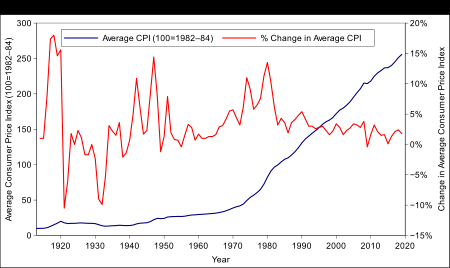

# Fake-data simulation and regression
Simulate 100 data points from the linear model, y = a + bx + error, with a = 5, b = 7, the values of x being samples at random from a uniform distribution on the range [0,50], and errors that are normally distributed with mean 0 and standard deviation 3.

In [204]:
a <- 5
b <- 7
N <- 100

x <- 50*runif(N)
error <- rnorm(N, sd=3) 
y <- a + b * x + error

In [205]:
fake_data <- tibble(x,y)
head(fake_data)

x,y
<dbl>,<dbl>
29.837336,208.26521
48.705640,353.71706
28.744709,206.94646
4.348672,35.51780
45.887757,327.29601
2.308871,22.53206


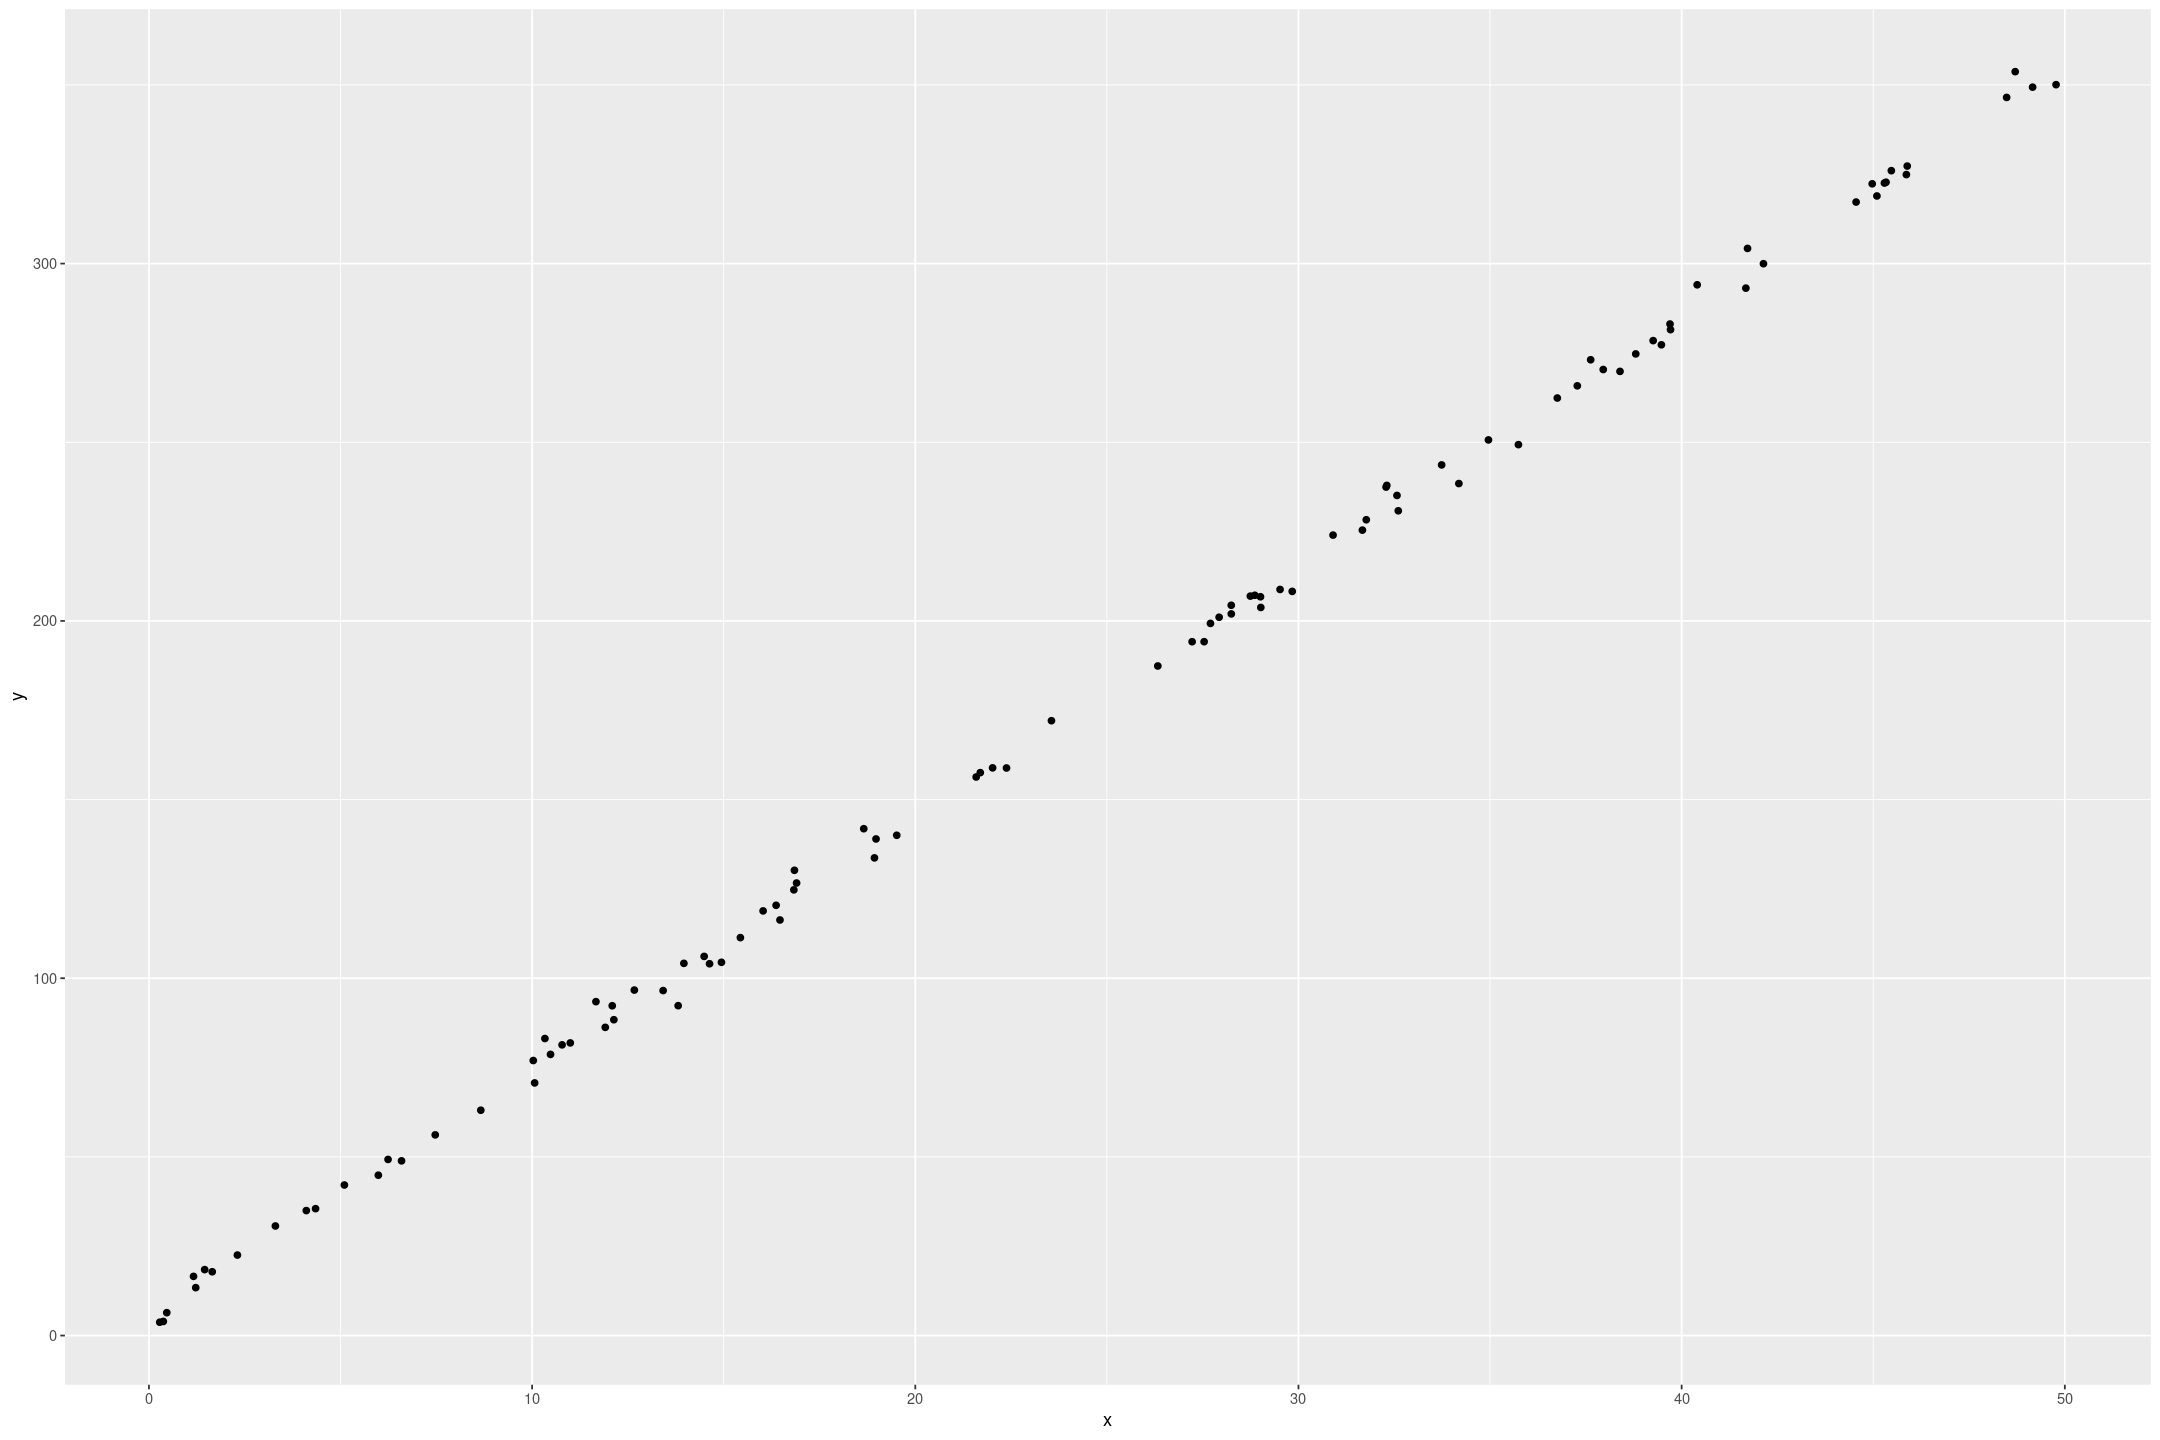

In [206]:
fake_data %>% gf_point(y ~ x)

In [207]:
fake_model <- stan_glm(y ~ x, data=fake_data)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 3.6e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.159254 seconds (Warm-up)
Chain 1:                0.139475 seconds (Sampling)
Chain 1:              

Estimates are close to model, especially for slope and standard deviation

In [208]:
print(fake_model)

stan_glm
 family:       gaussian [identity]
 formula:      y ~ x
 observations: 100
 predictors:   2
------
            Median MAD_SD
(Intercept) 4.8    0.6   
x           7.0    0.0   

Auxiliary parameter(s):
      Median MAD_SD
sigma 3.3    0.2   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


In [209]:
coef(fake_model)

(Intercept)           x 
   4.816995    7.010731

In [210]:
label_x <- 25
label_y <- coef(fake_model)[1] + label_x * coef(fake_model)[2]
label_text <- glue("y = {round(coef(fake_model)[1], 1)} + {format(round(coef(fake_model)[2], 1), nsmall=1)} x")

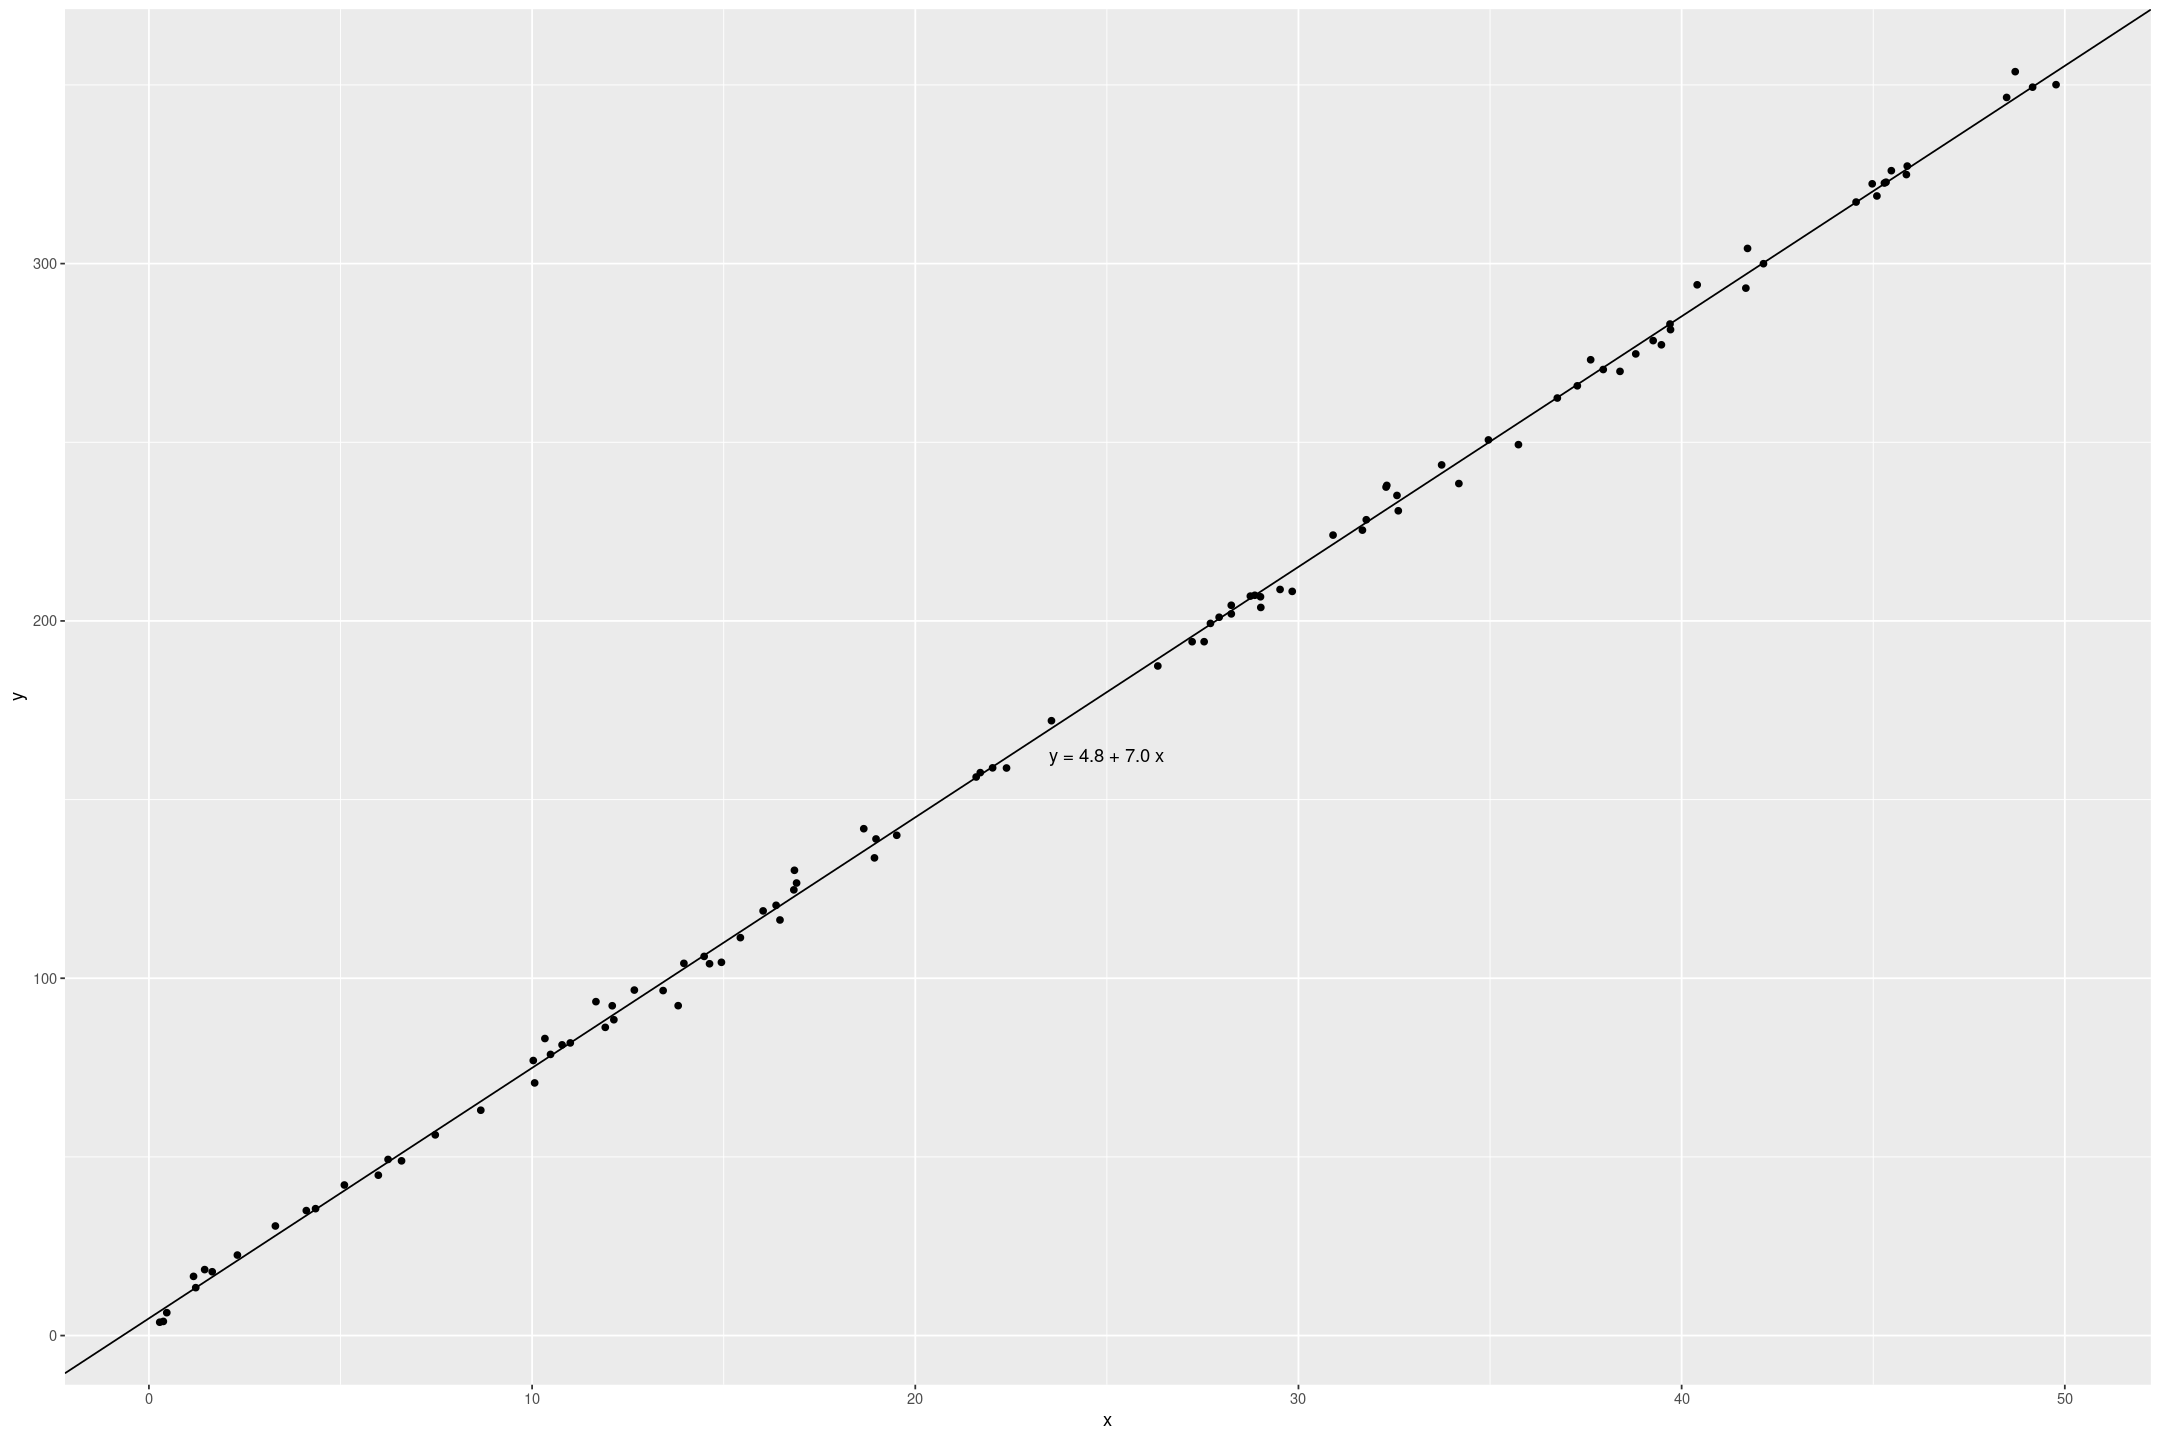

In [211]:
fake_data %>% gf_point(y ~ x) + geom_abline(intercept=coef(fake_model)[1], slope=coef(fake_model)[2]) + 
 geom_text(data=data.frame(x=label_x,y=label_y), aes(x, y), label=label_text, vjust=5)

# Fake-data simulation and fitting the wrong model
Simulate 100 data points from the linear model, y = a + bx + cx^2 + error, wtih the values of x being samples at random from a uniform distribution on the range [0,50], and errors that are normally distributed with mean 0 and standard deviation 3, and a, b, c chosen so that a scatterplot of the data shows a clear non-linear curve.

In [212]:
a <- 5
b <- 7
c <- 3
N <- 100

x <- 50*runif(N)
error <- rnorm(N, sd=3) 
y <- a + b * x + c*x^2 + error

In [213]:
fake_data <- tibble(x,y)
head(fake_data)

x,y
<dbl>,<dbl>
20.65298,1429.0197
34.27005,3766.2324
13.73226,666.7976
26.92756,2365.0453
45.21392,6451.5240
20.76559,1447.6075


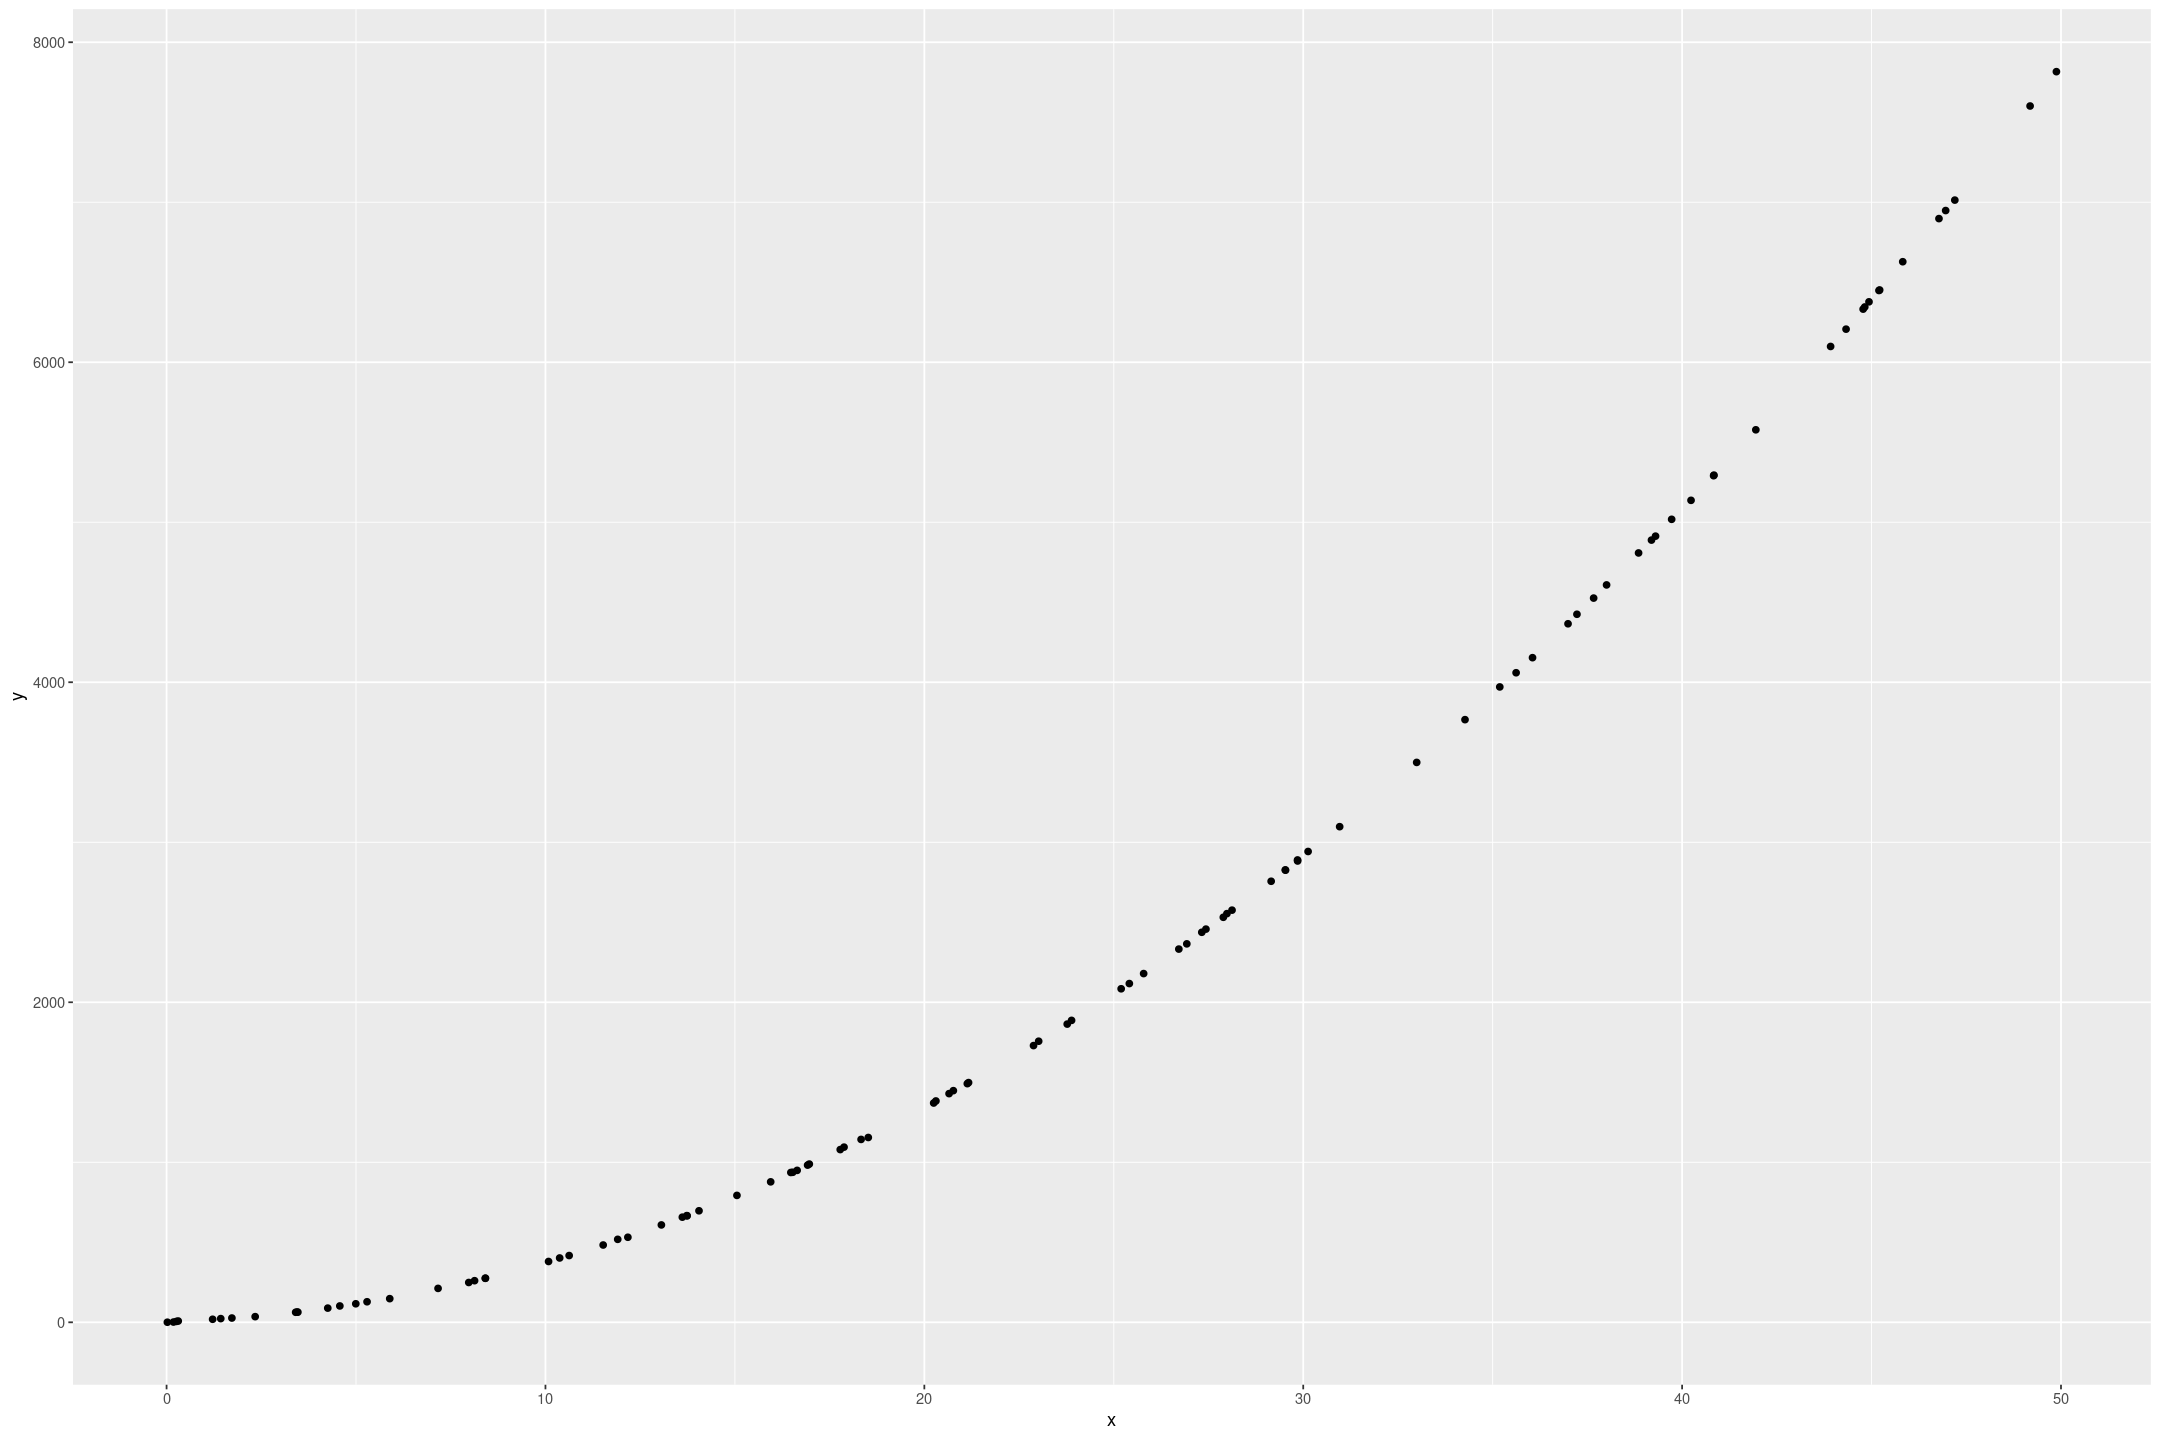

In [214]:
fake_data %>% gf_point(y ~ x)

a) Fitting a regression line `stan_glm(y ~ x)` to the data

In [215]:
model <- stan_glm(y ~ x, data=fake_data)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.2e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.22466 seconds (Warm-up)
Chain 1:                0.048369 seconds (Sampling)
Chain 1:               

Notice the parameters are large, especially the error!

In [216]:
print(model)

stan_glm
 family:       gaussian [identity]
 formula:      y ~ x
 observations: 100
 predictors:   2
------
            Median  MAD_SD 
(Intercept) -1108.9   110.2
x             151.5     4.0

Auxiliary parameter(s):
      Median MAD_SD
sigma 584.9   41.8 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


We can still find a line of best fit (minimising the sum of squared error), but it's far from the actual model.

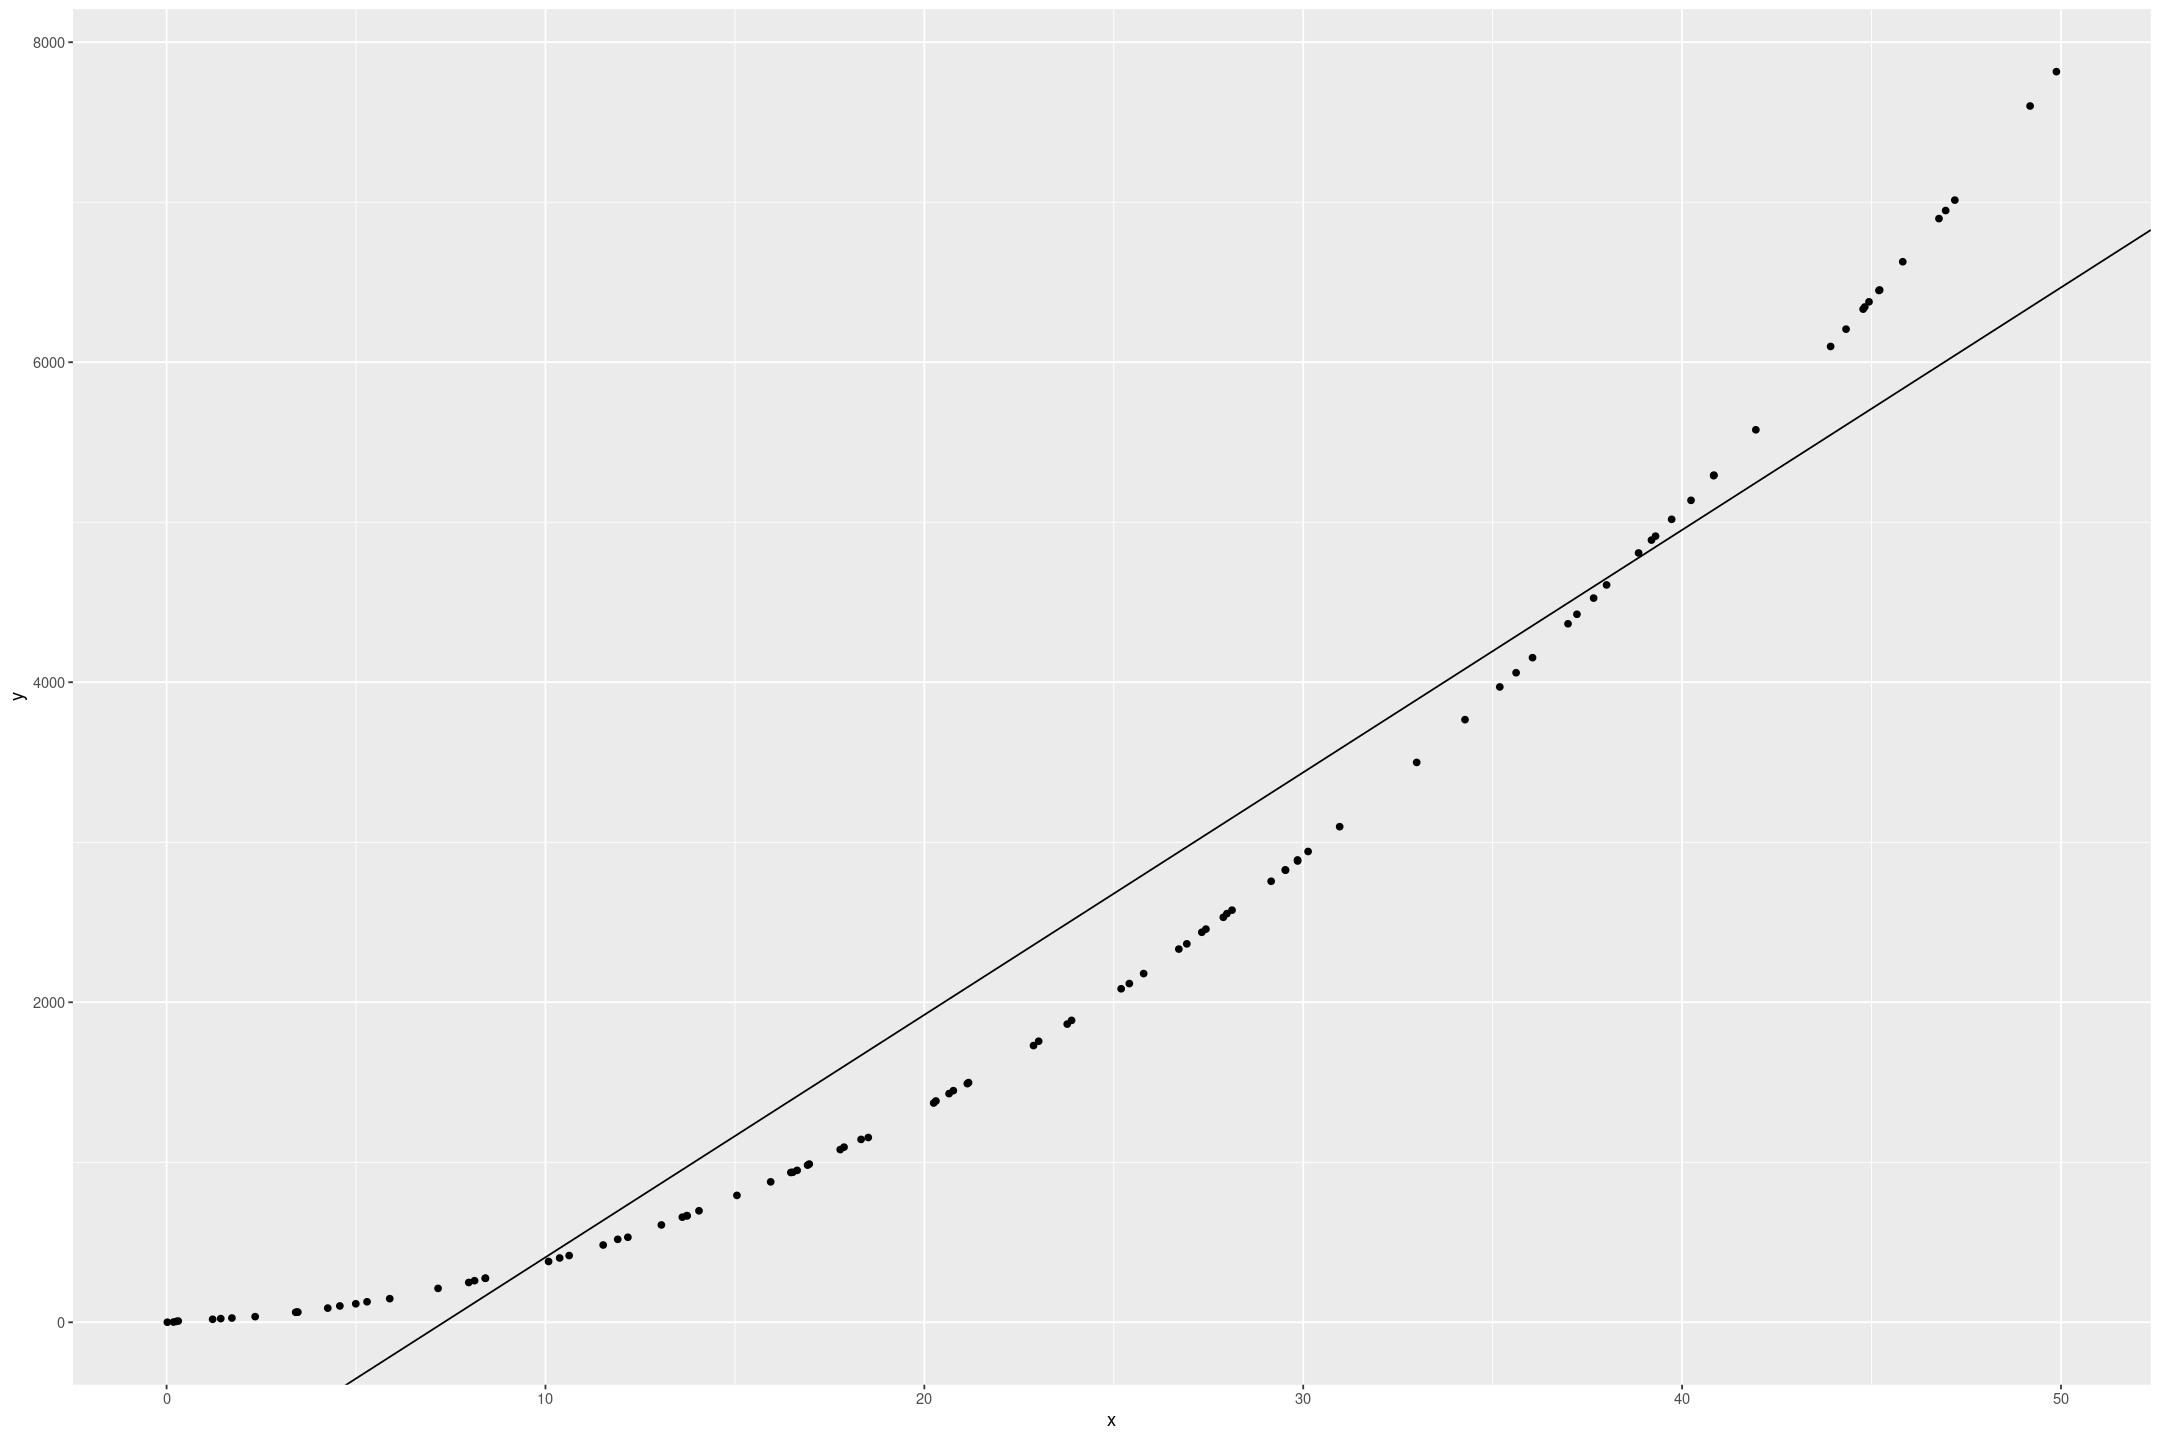

In [217]:
fake_data %>% gf_point(y ~ x) + geom_abline(intercept=coef(model)[1], slope = coef(model)[2])

We could extend the model to fit a quadratic by adding a predictor

In [218]:
fake_data <- fake_data %>% mutate(x2 = x*x)
head(fake_data)

x,y,x2
<dbl>,<dbl>,<dbl>
20.65298,1429.0197,426.5454
34.27005,3766.2324,1174.4365
13.73226,666.7976,188.5749
26.92756,2365.0453,725.0936
45.21392,6451.5240,2044.2985
20.76559,1447.6075,431.2098


In [219]:
quadratic_model <- stan_glm(y ~ x + x2, data=fake_data)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 3.4e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1.60514 seconds (Warm-up)
Chain 1:                1.0615 seconds (Sampling)
Chain 1:                2

Fits the model very well

In [220]:
print(quadratic_model)

stan_glm
 family:       gaussian [identity]
 formula:      y ~ x + x2
 observations: 100
 predictors:   3
------
            Median MAD_SD
(Intercept) 4.1    0.7   
x           7.1    0.1   
x2          3.0    0.0   

Auxiliary parameter(s):
      Median MAD_SD
sigma 2.7    0.2   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


In [221]:
coef(quadratic_model)

(Intercept)           x          x2 
   4.054152    7.064511    2.998499

In [222]:
fitted_curve <- tibble(x=seq(0, 50, by=0.1)) %>% mutate(y = coef(quadratic_model)[1] + coef(quadratic_model)[2] * x + coef(quadratic_model)[3] * x^2)

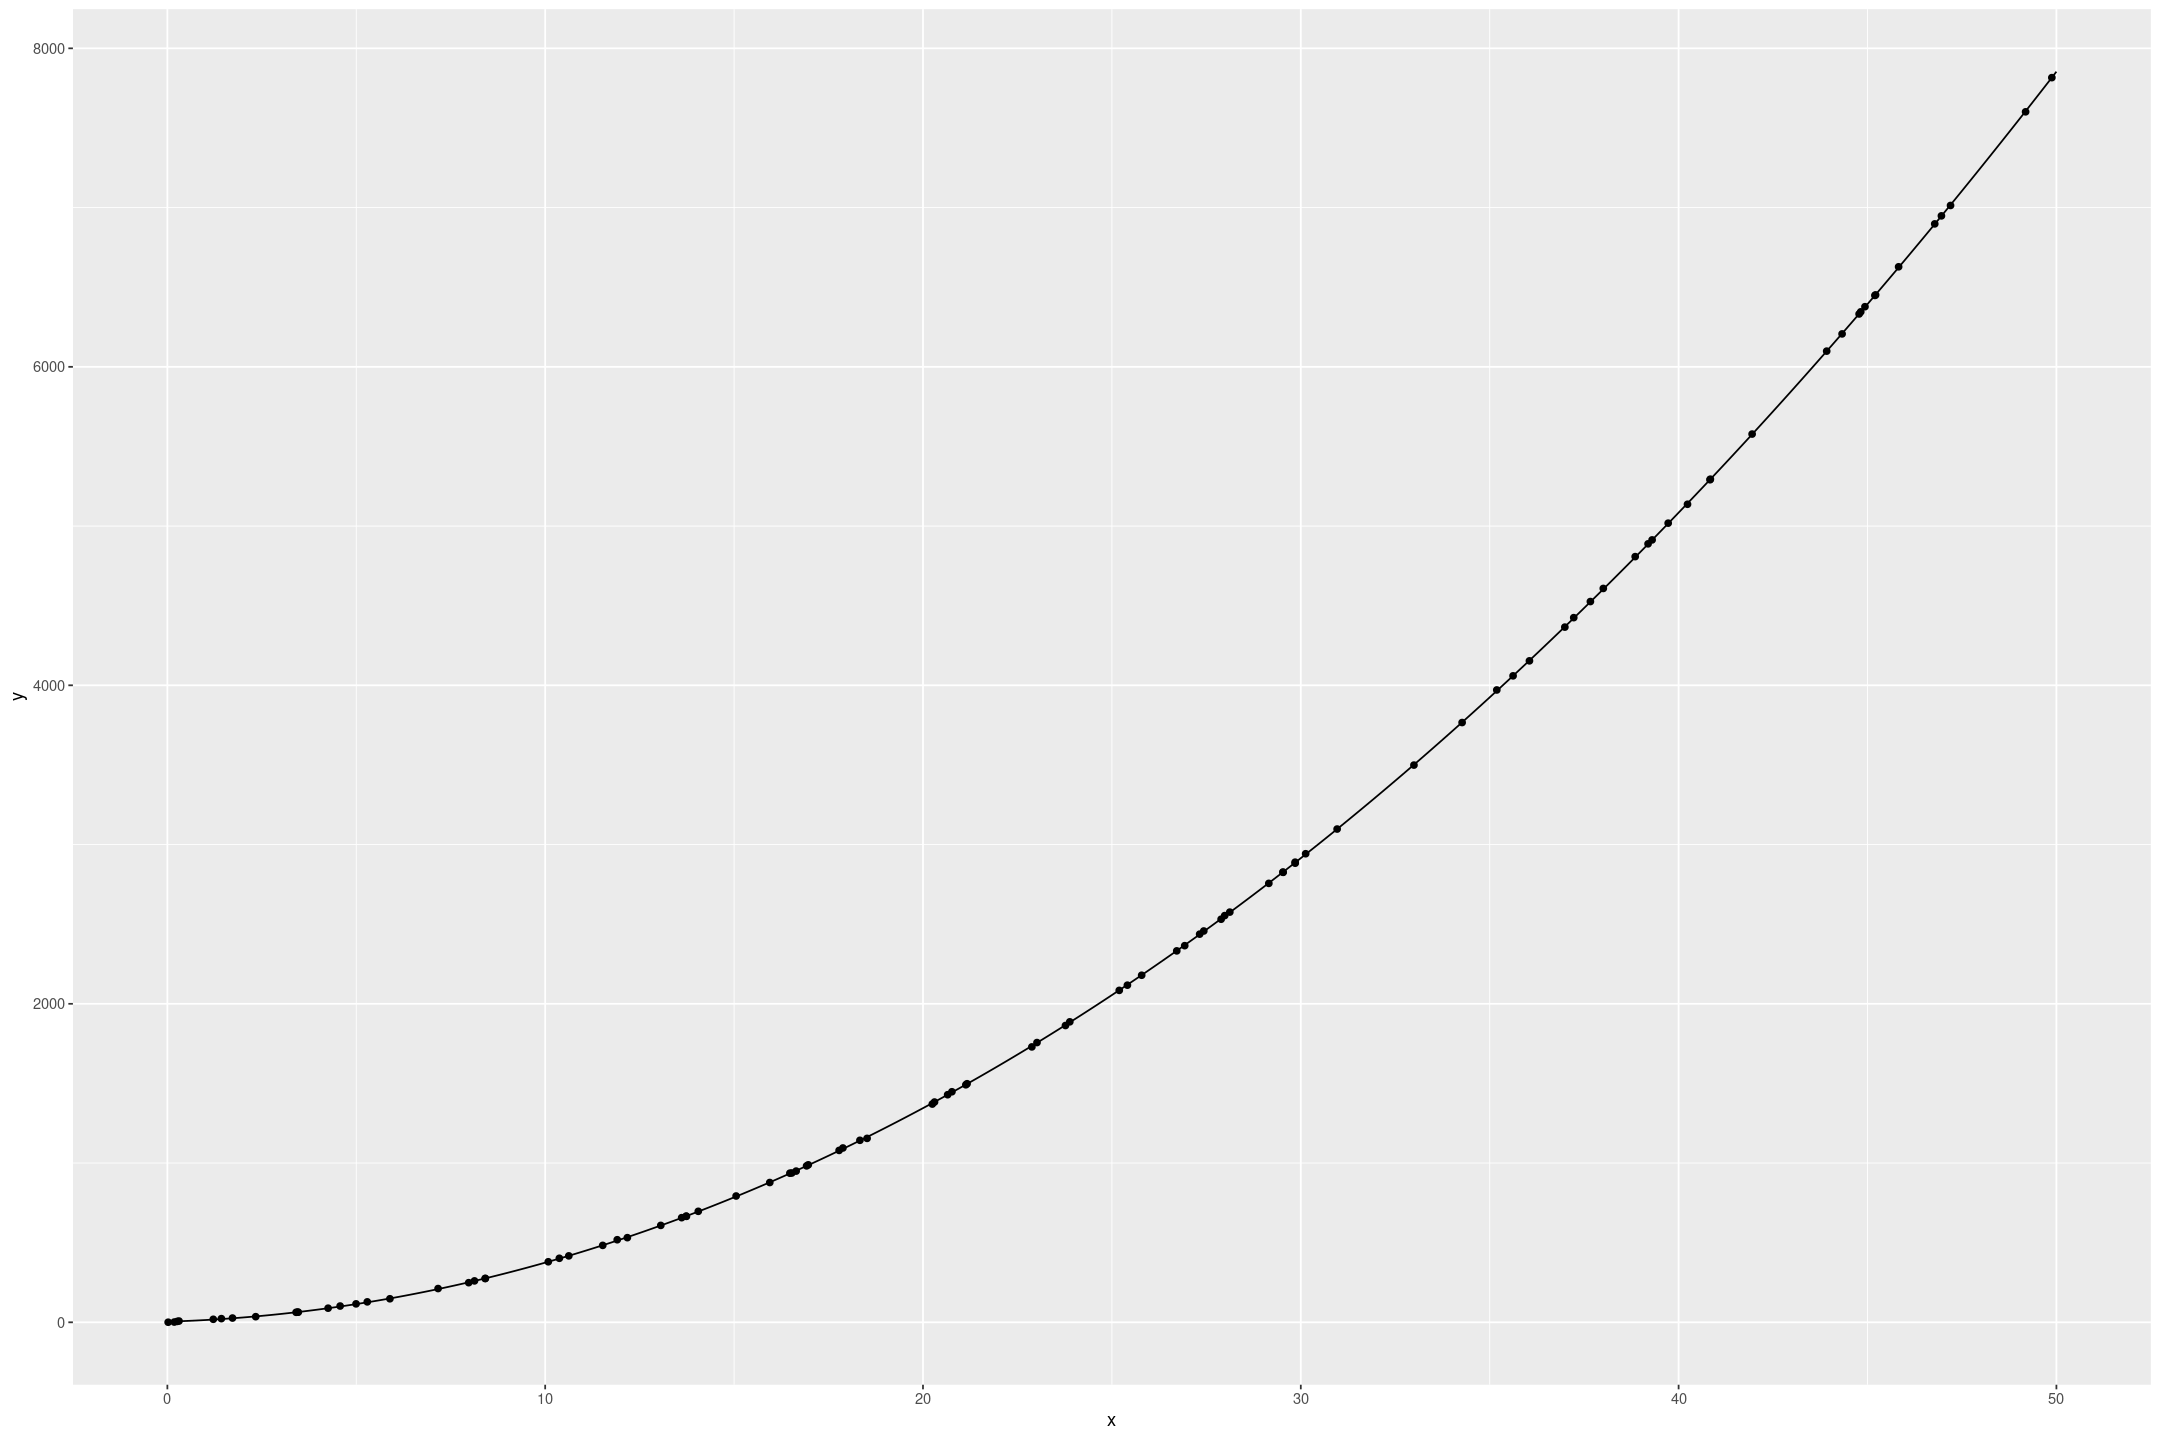

In [223]:
fake_data %>% gf_point(y ~ x) %>% gf_line(y ~ x, data=fitted_curve)

# Prediction
Following the template of Section 7.1, find data in which one variable can be used to predict the other, then fit a linear model and plot it along with the data, then display the model and explain in words as on page 95. Use the model to obtain a probabalistic prediction for new data, and evaluate that prediction, as in the last part of Section 7.1.

## Getting Data

I've heard that religiosity is strongly correlated with fertility. Let's check this.

For religiosity Wikipedia has a copy of [Gallup Data](https://news.gallup.com/poll/142727/religiosity-highest-world-poorest-nations.aspx) from 2009 about "Is religion important in your daily life?".
It's based on a sample of 1000 people per country, using telephone and in person surveys.

In [224]:
importance_religion_html <- xml2::read_html("https://en.wikipedia.org/wiki/Importance_of_religion_by_country")

In [225]:
importance_religion_raw <- importance_religion_html %>%
rvest::html_nodes("table") %>% 
.[[2]] %>%
rvest::html_table()

importance_religion_raw

Rank,Country,"Yes, important[1]","No, unimportant[1]"
<int>,<chr>,<chr>,<chr>
1,Estonia,14%,86%
2,Sweden,15%,85%
3,Denmark,19%,81%
4,Czech Republic[a],21%,75%
5,Norway[a],22%,78%
6,Japan,24%,75%
7,Hong Kong,24%,74%
8,United Kingdom,27%,73%
9,Finland[a],28%,70%


The columns with an `[a]` in the name are from a 2008 survey; which is probably close enough.

Let's normalise this by:

* Renaming the columns to something nice
* Separating out the `[a]` annotaion as a survey year identifier
* Removing the `[a]` from country names
* Extracting the country code (which is unambiguous as opposed to country name, which can be different e.g. Russia vs Russian Federation)
* Converting percentage strings to decimal

In [226]:
convert_percent <- function(x)
    as.numeric(str_remove(x, "%$"))/100

In [227]:
importance_religion <- 
importance_religion_raw %>% 
rename_with(~str_remove(tolower(.), ",.*")) %>%
mutate(year=if_else(str_ends(country, '[a]'), 2008L, 2009L),
       country = as.factor(str_remove(country, "\\[a\\]$")),
       iso2c = countrycode::countrycode(country, origin='country.name', destination='iso2c'),
       yes = convert_percent(yes),
       no = convert_percent(no))

importance_religion

rank,country,yes,no,year,iso2c
<int>,<fct>,<dbl>,<dbl>,<int>,<chr>
1,Estonia,0.14,0.86,2008,EE
2,Sweden,0.15,0.85,2009,SE
3,Denmark,0.19,0.81,2009,DK
4,Czech Republic,0.21,0.75,2009,CZ
5,Norway,0.22,0.78,2009,NO
6,Japan,0.24,0.75,2009,JP
7,Hong Kong,0.24,0.74,2009,HK
8,United Kingdom,0.27,0.73,2009,GB
9,Finland,0.28,0.70,2009,FI


[Fertility rate, total (births per woman)](https://data.worldbank.org/indicator/SP.DYN.TFRT.IN) data from World Bank

In [228]:
fertility <- WDI::WDI(country=importance_religion$iso2c, indicator="SP.DYN.TFRT.IN", start=2008, end=2009) %>%
rename(fertility = "SP.DYN.TFRT.IN")

In [229]:
fertility %>% t()

iso2c,AF,AF,AO,AO,AL,AL,AE,AE,AR,AR,AM,AM,AU,AU,AT,AT,AZ,AZ,BI,BI,BE,BE,BJ,BJ,BF,BF,BD,BD,BG,BG,BH,BH,BA,BA,BY,BY,BZ,BZ,BO,BO,BR,BR,BW,BW,CF,CF,CA,CA,CH,CH,CL,CL,CI,CI,CM,CM,CD,CD,CG,CG,CO,CO,KM,KM,CR,CR,CU,CU,CY,CY,CZ,CZ,DE,DE,DJ,⋯,PL,PT,PT,PY,PY,PS,PS,QA,QA,RO,RO,RU,RU,RW,RW,SA,SA,SD,SD,SN,SN,SG,SG,SO,SO,RS,RS,SK,SK,SI,SI,SE,SE,SY,SY,TD,TD,TG,TG,TH,TH,TJ,TJ,TM,TM,TT,TT,TN,TN,TR,TR,TZ,TZ,UG,UG,UA,UA,UY,UY,US,US,UZ,UZ,VE,VE,VN,VN,YE,YE,ZA,ZA,ZM,ZM,ZW,ZW
country,Afghanistan,Afghanistan,Angola,Angola,Albania,Albania,United Arab Emirates,United Arab Emirates,Argentina,Argentina,Armenia,Armenia,Australia,Australia,Austria,Austria,Azerbaijan,Azerbaijan,Burundi,Burundi,Belgium,Belgium,Benin,Benin,Burkina Faso,Burkina Faso,Bangladesh,Bangladesh,Bulgaria,Bulgaria,Bahrain,Bahrain,Bosnia and Herzegovina,Bosnia and Herzegovina,Belarus,Belarus,Belize,Belize,Bolivia,Bolivia,Brazil,Brazil,Botswana,Botswana,Central African Republic,Central African Republic,Canada,Canada,Switzerland,Switzerland,Chile,Chile,Cote d'Ivoire,Cote d'Ivoire,Cameroon,Cameroon,"Congo, Dem. Rep.","Congo, Dem. Rep.","Congo, Rep.","Congo, Rep.",Colombia,Colombia,Comoros,Comoros,Costa Rica,Costa Rica,Cuba,Cuba,Cyprus,Cyprus,Czech Republic,Czech Republic,Germany,Germany,Djibouti,⋯,Poland,Portugal,Portugal,Paraguay,Paraguay,West Bank and Gaza,West Bank and Gaza,Qatar,Qatar,Romania,Romania,Russian Federation,Russian Federation,Rwanda,Rwanda,Saudi Arabia,Saudi Arabia,Sudan,Sudan,Senegal,Senegal,Singapore,Singapore,Somalia,Somalia,Serbia,Serbia,Slovak Republic,Slovak Republic,Slovenia,Slovenia,Sweden,Sweden,Syrian Arab Republic,Syrian Arab Republic,Chad,Chad,Togo,Togo,Thailand,Thailand,Tajikistan,Tajikistan,Turkmenistan,Turkmenistan,Trinidad and Tobago,Trinidad and Tobago,Tunisia,Tunisia,Turkey,Turkey,Tanzania,Tanzania,Uganda,Uganda,Ukraine,Ukraine,Uruguay,Uruguay,United States,United States,Uzbekistan,Uzbekistan,"Venezuela, RB","Venezuela, RB",Vietnam,Vietnam,"Yemen, Rep.","Yemen, Rep.",South Africa,South Africa,Zambia,Zambia,Zimbabwe,Zimbabwe
fertility,6.1800,6.3730,6.2600,6.3200,1.6520,1.6540,1.8770,1.9390,2.3550,2.3660,1.7190,1.7120,1.9710,1.9840,1.3900,1.4200,1.8200,1.9000,6.2670,6.3520,1.8400,1.8500,5.4160,5.4690,5.9530,6.0360,2.3820,2.4490,1.6600,1.5600,2.1970,2.2410,1.3110,1.3030,1.5090,1.4880,2.7490,2.8160,3.2870,3.3640,1.8180,1.8470,3.0260,3.0340,5.2540,5.2890,1.6680,1.6808,1.5000,1.4800,1.8920,1.8950,5.1520,5.2210,5.1670,5.2190,6.5870,6.6210,4.7840,4.7980,2.0330,2.0810,4.8130,4.8700,1.9030,1.9230,1.6240,1.6020,1.4430,1.4610,1.5100,1.5100,1.3600,1.3800,3.3970,⋯,1.3900,1.3400,1.3900,2.7870,2.8460,4.5040,4.5670,2.1300,2.2110,1.6600,1.6000,1.5420,1.5020,4.6410,4.7670,3.0660,3.1580,4.9260,4.9770,5.0810,5.0940,1.2200,1.2800,6.9610,7.0550,1.4400,1.4000,1.4400,1.3400,1.5300,1.5300,1.9400,1.9100,3.5140,3.6130,6.6990,6.8030,4.9360,5.0010,1.5450,1.5490,3.5960,3.5940,2.7690,2.7120,1.8040,1.7990,2.0950,2.0540,2.1680,2.1890,5.4890,5.5420,6.2270,6.3330,1.4730,1.4580,2.0180,2.0300,2.0020,2.0720,2.5300,2.6370,2.5000,2.5300,1.9280,1.9180,4.8010,4.9400,2.6080,2.6110,5.4960,5.5740,3.9880,3.9310
year,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,⋯,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008,2009,2008


We could try to join on country name but we miss a few

In [230]:
religion_fertility <- 
importance_religion %>% rename(religion=yes) %>% select(-no) %>%
left_join(fertility %>% select(-country), by=c('iso2c', 'year'))

religion_fertility

rank,country,religion,year,iso2c,fertility
<int>,<fct>,<dbl>,<int>,<chr>,<dbl>
1,Estonia,0.14,2008,EE,1.7200
2,Sweden,0.15,2009,SE,1.9400
3,Denmark,0.19,2009,DK,1.8400
4,Czech Republic,0.21,2009,CZ,1.5100
5,Norway,0.22,2009,NO,1.9800
6,Japan,0.24,2009,JP,1.3700
7,Hong Kong,0.24,2009,HK,1.0550
8,United Kingdom,0.27,2009,GB,1.8900
9,Finland,0.28,2009,FI,1.8600


Only missing Taiwan, probably for political reasons.

Let's drop it for now.

In [231]:
religion_fertility %>% filter(is.na(fertility))

rank,country,religion,year,iso2c,fertility
<int>,<fct>,<dbl>,<int>,<chr>,<dbl>
30,Taiwan,0.45,2009,TW,NA


In [232]:
religion_fertility <- religion_fertility %>% filter(!is.na(fertility))

There definitely a positive correlation between importance of religion and fertility, but it looks more than linear.

Warning message:
“ggrepel: 9 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


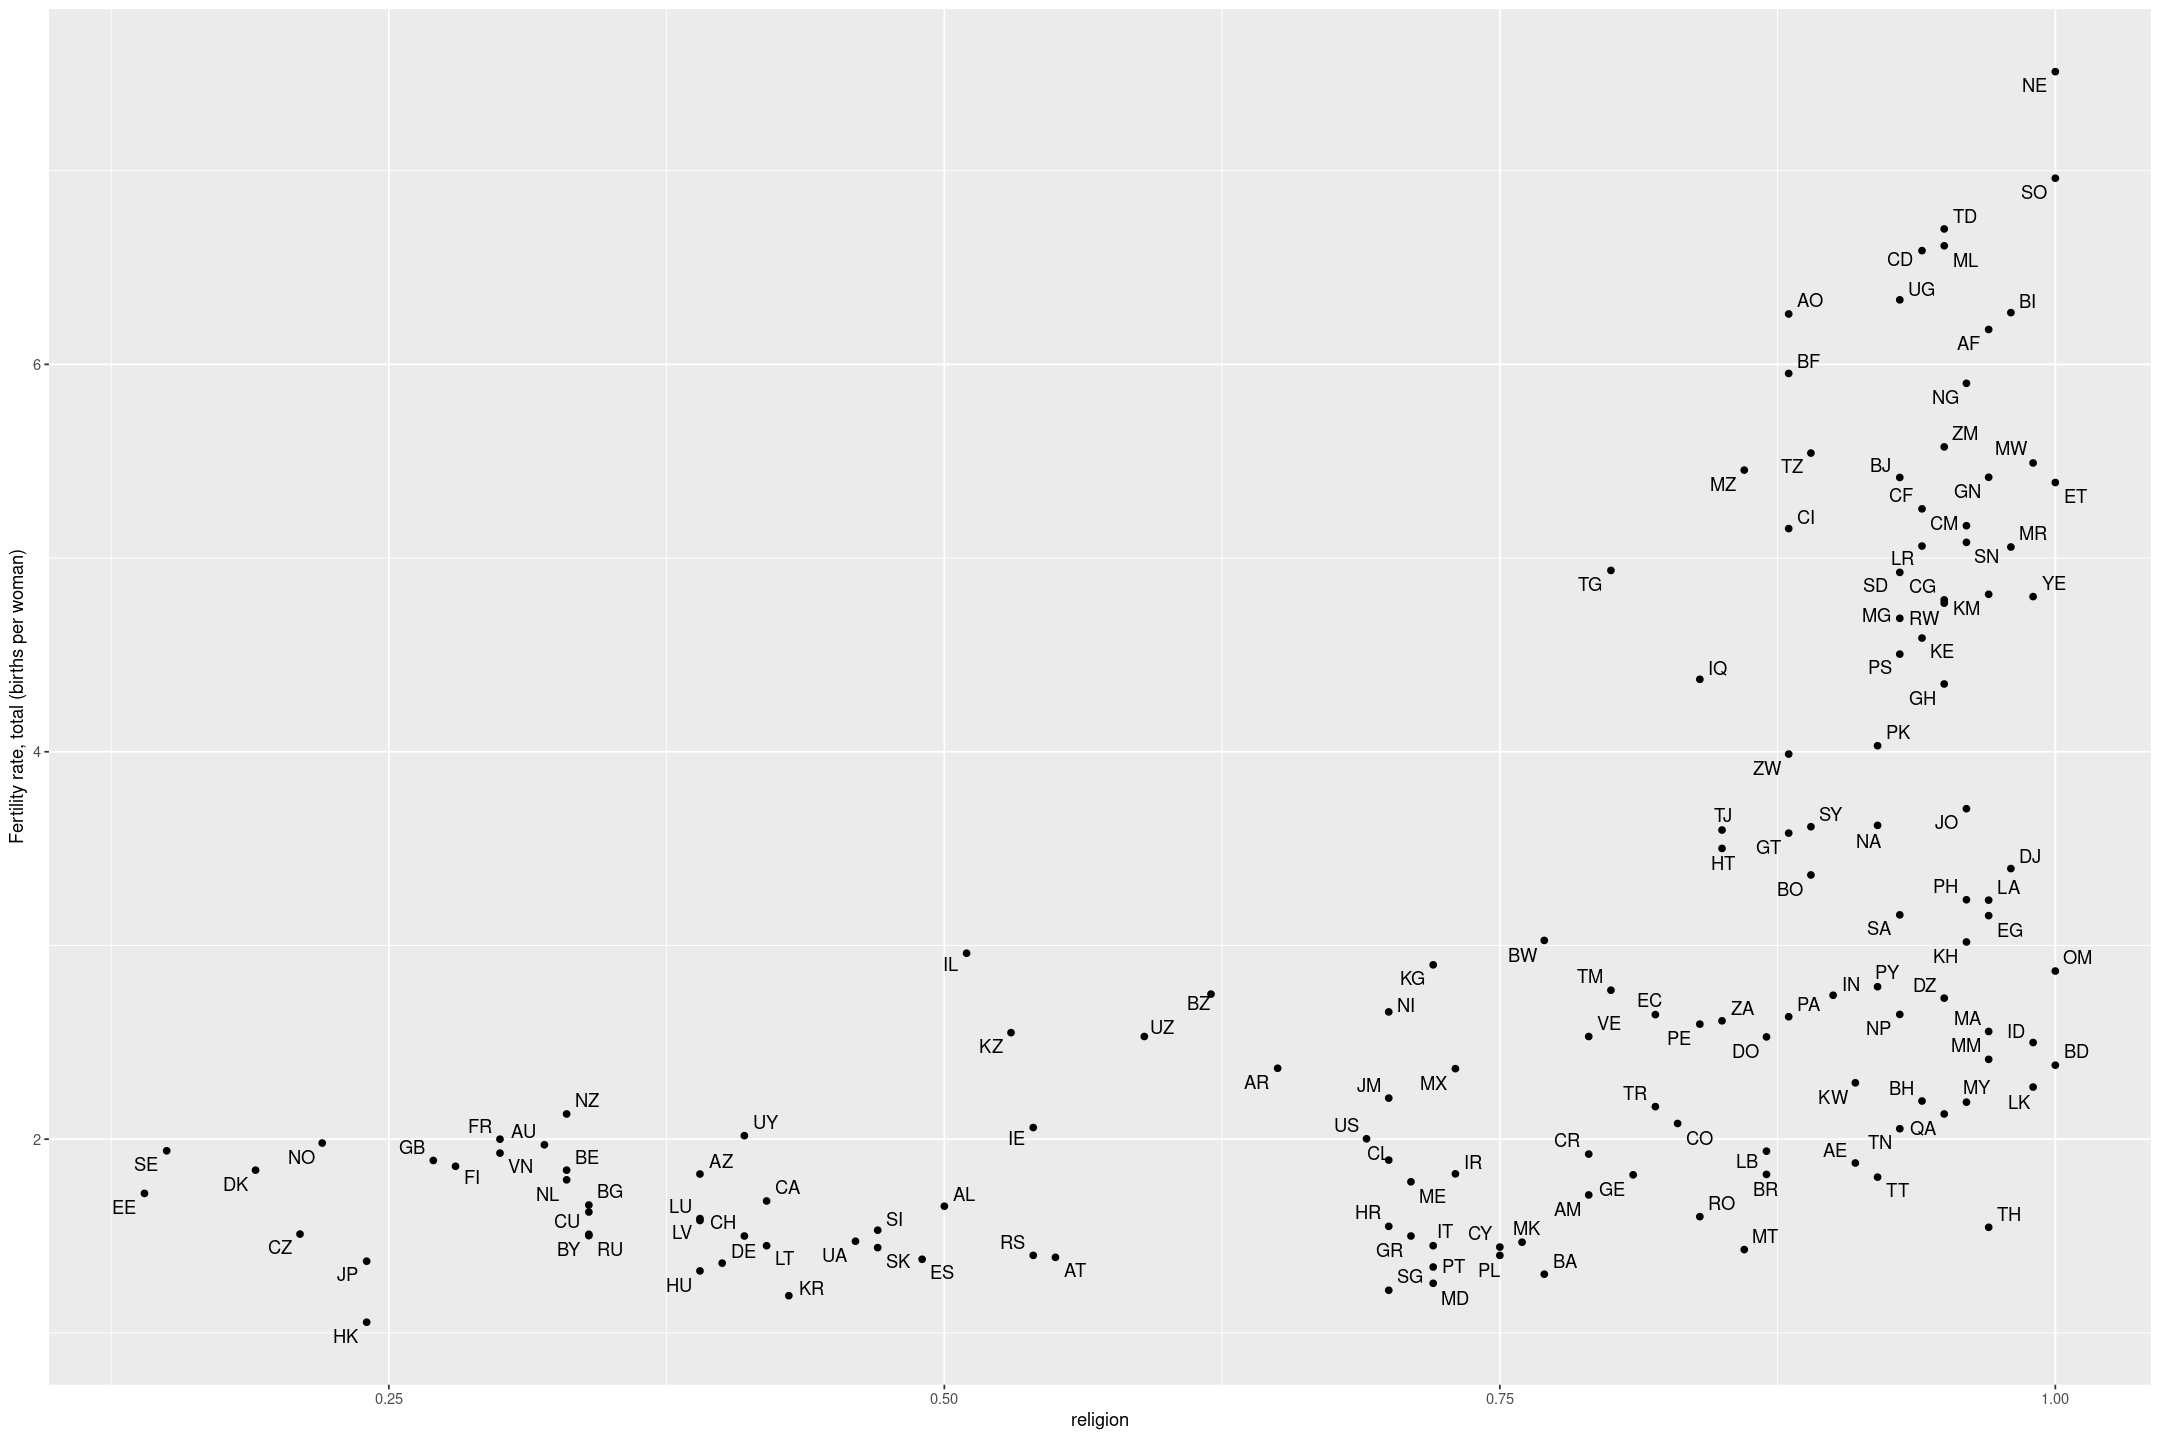

In [241]:
religion_fertility %>% gf_point(fertility ~ religion) + ggrepel::geom_text_repel(aes(label=iso2c))

In [243]:
religion_fertility %>% arrange(desc(fertility)) %>% head()

,rank,country,religion,year,iso2c,fertility
,<int>,<fct>,<dbl>,<int>,<chr>,<dbl>
1,145,Niger,1.00,2009,NE,7.511
2,147,Somalia,1.00,2009,SO,6.961
3,119,Chad,0.95,2009,TD,6.699
4,122,Mali,0.95,2009,ML,6.612
5,113,Democratic Republic of the Congo,0.94,2009,CD,6.587
6,104,Uganda,0.93,2008,UG,6.333


In [244]:
religion_fertility %>% arrange(fertility) %>% head()

,rank,country,religion,year,iso2c,fertility
,<int>,<fct>,<dbl>,<int>,<chr>,<dbl>
1,7,Hong Kong,0.24,2009,HK,1.055
2,29,South Korea,0.43,2008,KR,1.192
3,48,Singapore,0.70,2009,SG,1.220
4,54,Moldova,0.72,2008,MD,1.256
5,64,Bosnia and Herzegovina,0.77,2008,BA,1.303
6,22,Hungary,0.39,2009,HU,1.320


Log transforming fertility gives something closer to linear.

Warning message:
“ggrepel: 12 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


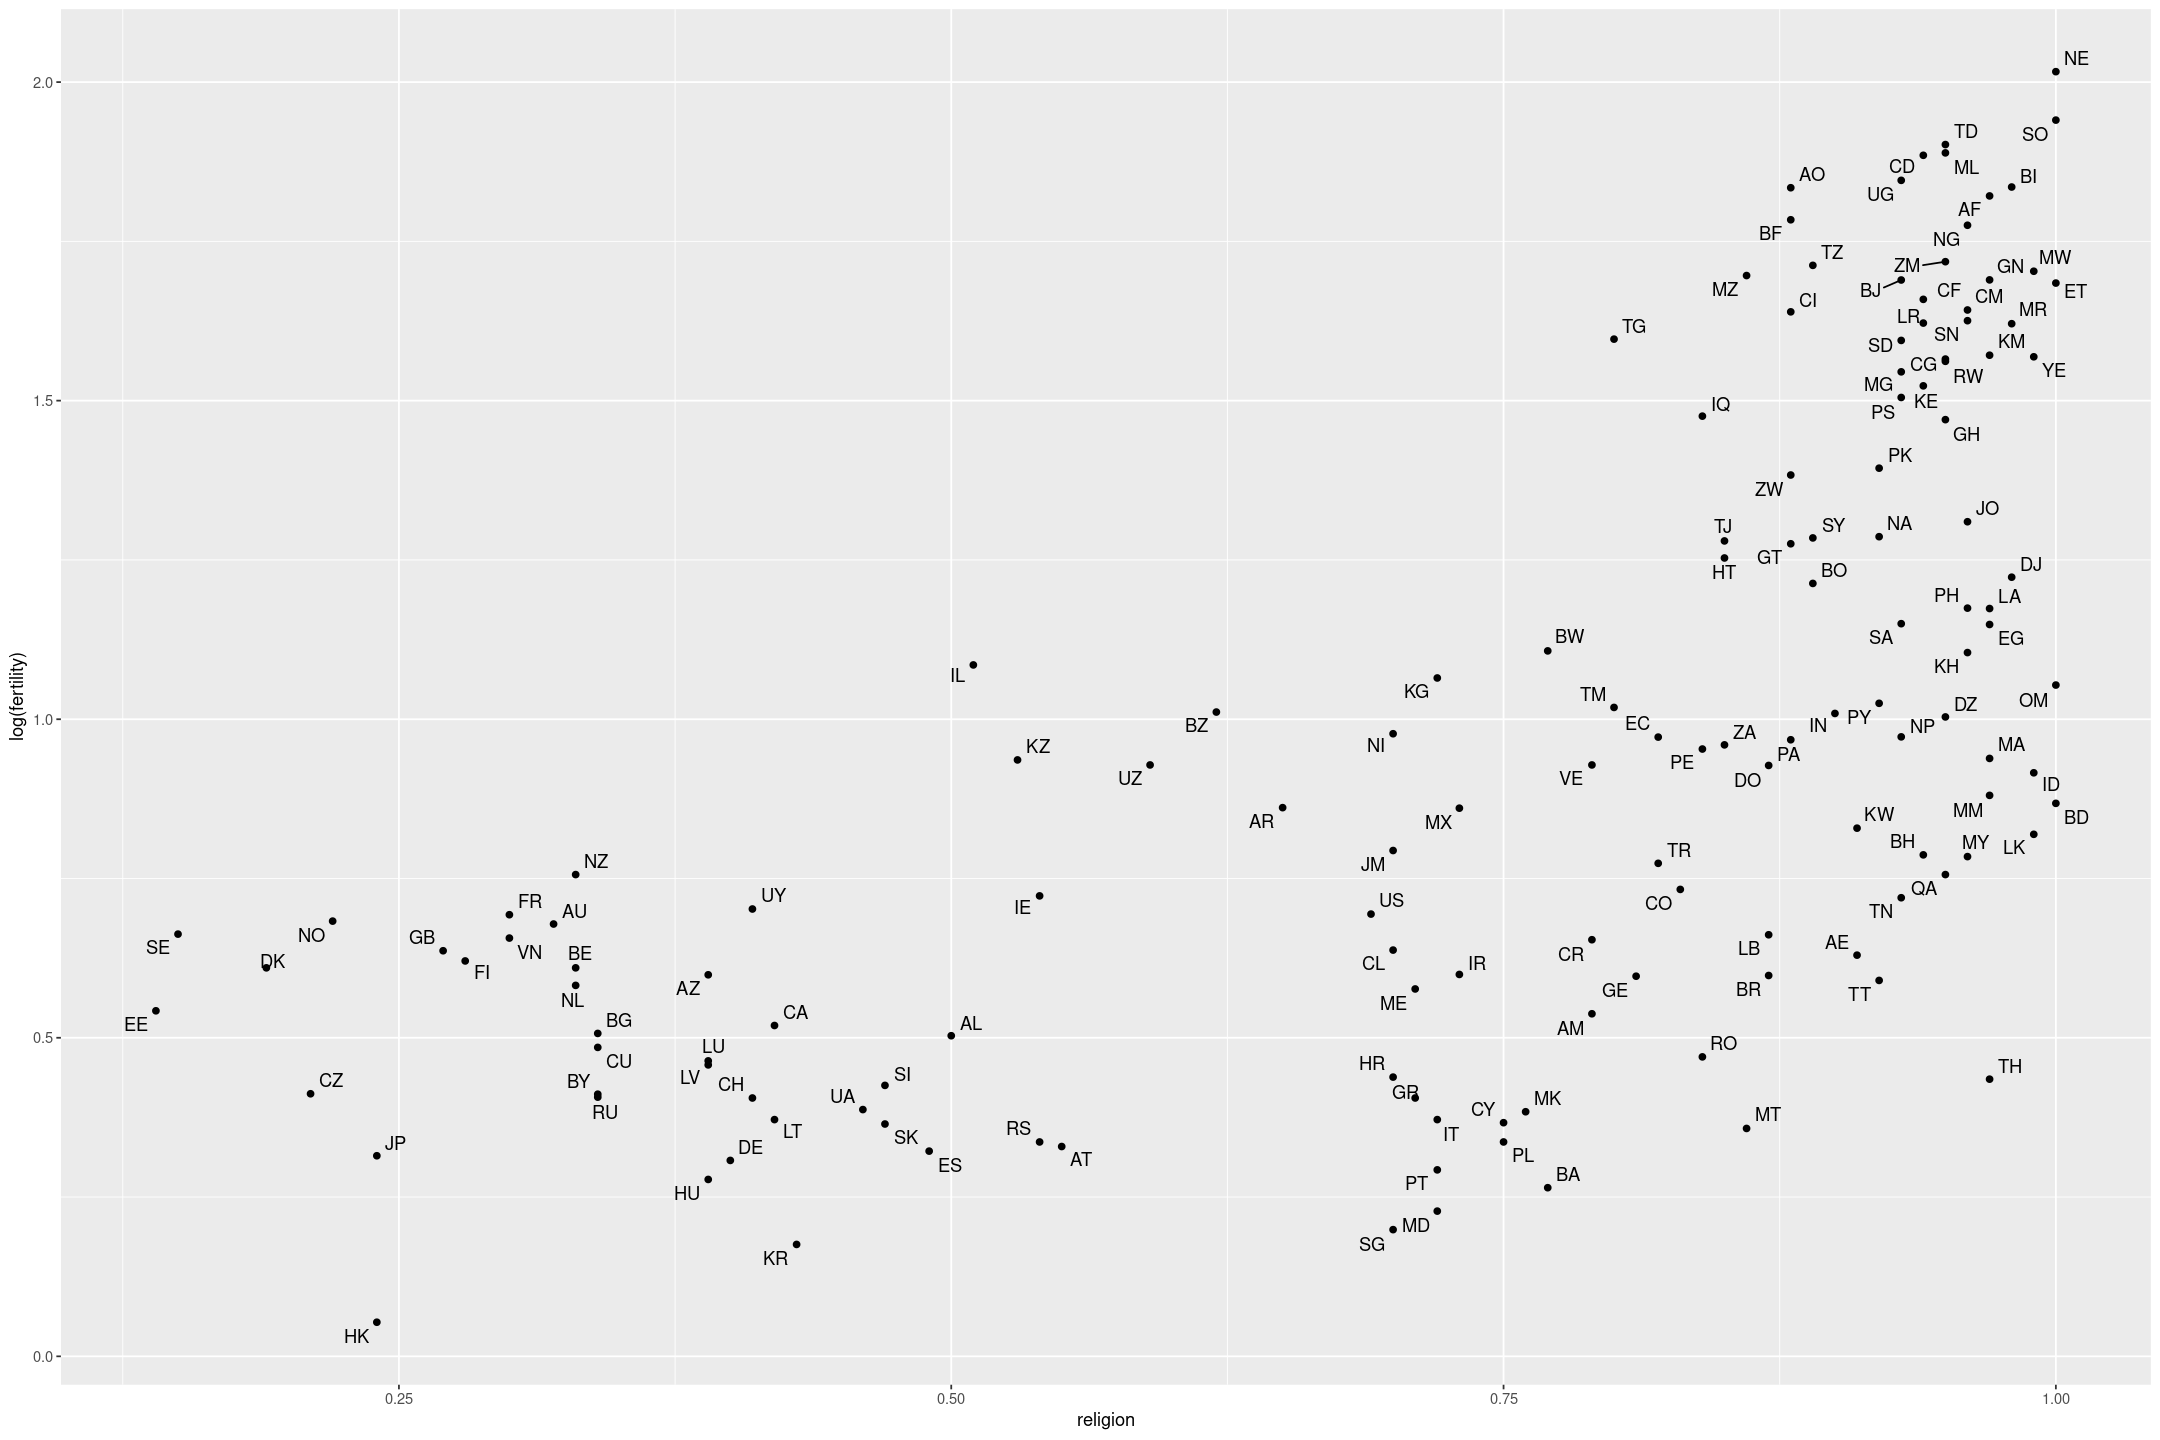

In [240]:
religion_fertility %>% gf_point(log(fertility) ~ religion) + ggrepel::geom_text_repel(aes(label=iso2c))

## Fitting a model

In [246]:
religion_fertility <- religion_fertility %>%
mutate(logfertility = log(fertility))

In [249]:
religion_fertility_model <- stan_glm(log(fertility) ~ religion, data=religion_fertility)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000558 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 5.58 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.086992 seconds (Warm-up)
Chain 1:                0.145604 seconds (Sampling)
Chain 1:             

In [250]:
print(religion_fertility_model)

stan_glm
 family:       gaussian [identity]
 formula:      log(fertility) ~ religion
 observations: 145
 predictors:   2
------
            Median MAD_SD
(Intercept) 0.0    0.1   
religion    1.3    0.1   

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.4    0.0   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


This gives a pretty confident model on `log(fertility) ~ 1.3 * religion`

That is `fertility ~ exp(1.3 * religion)`

In [255]:
intercept = coef(religion_fertility_model)[1]
slope = coef(religion_fertility_model)[2]
c(intercept, slope)

(Intercept)    religion 
-0.02154959  1.32062080

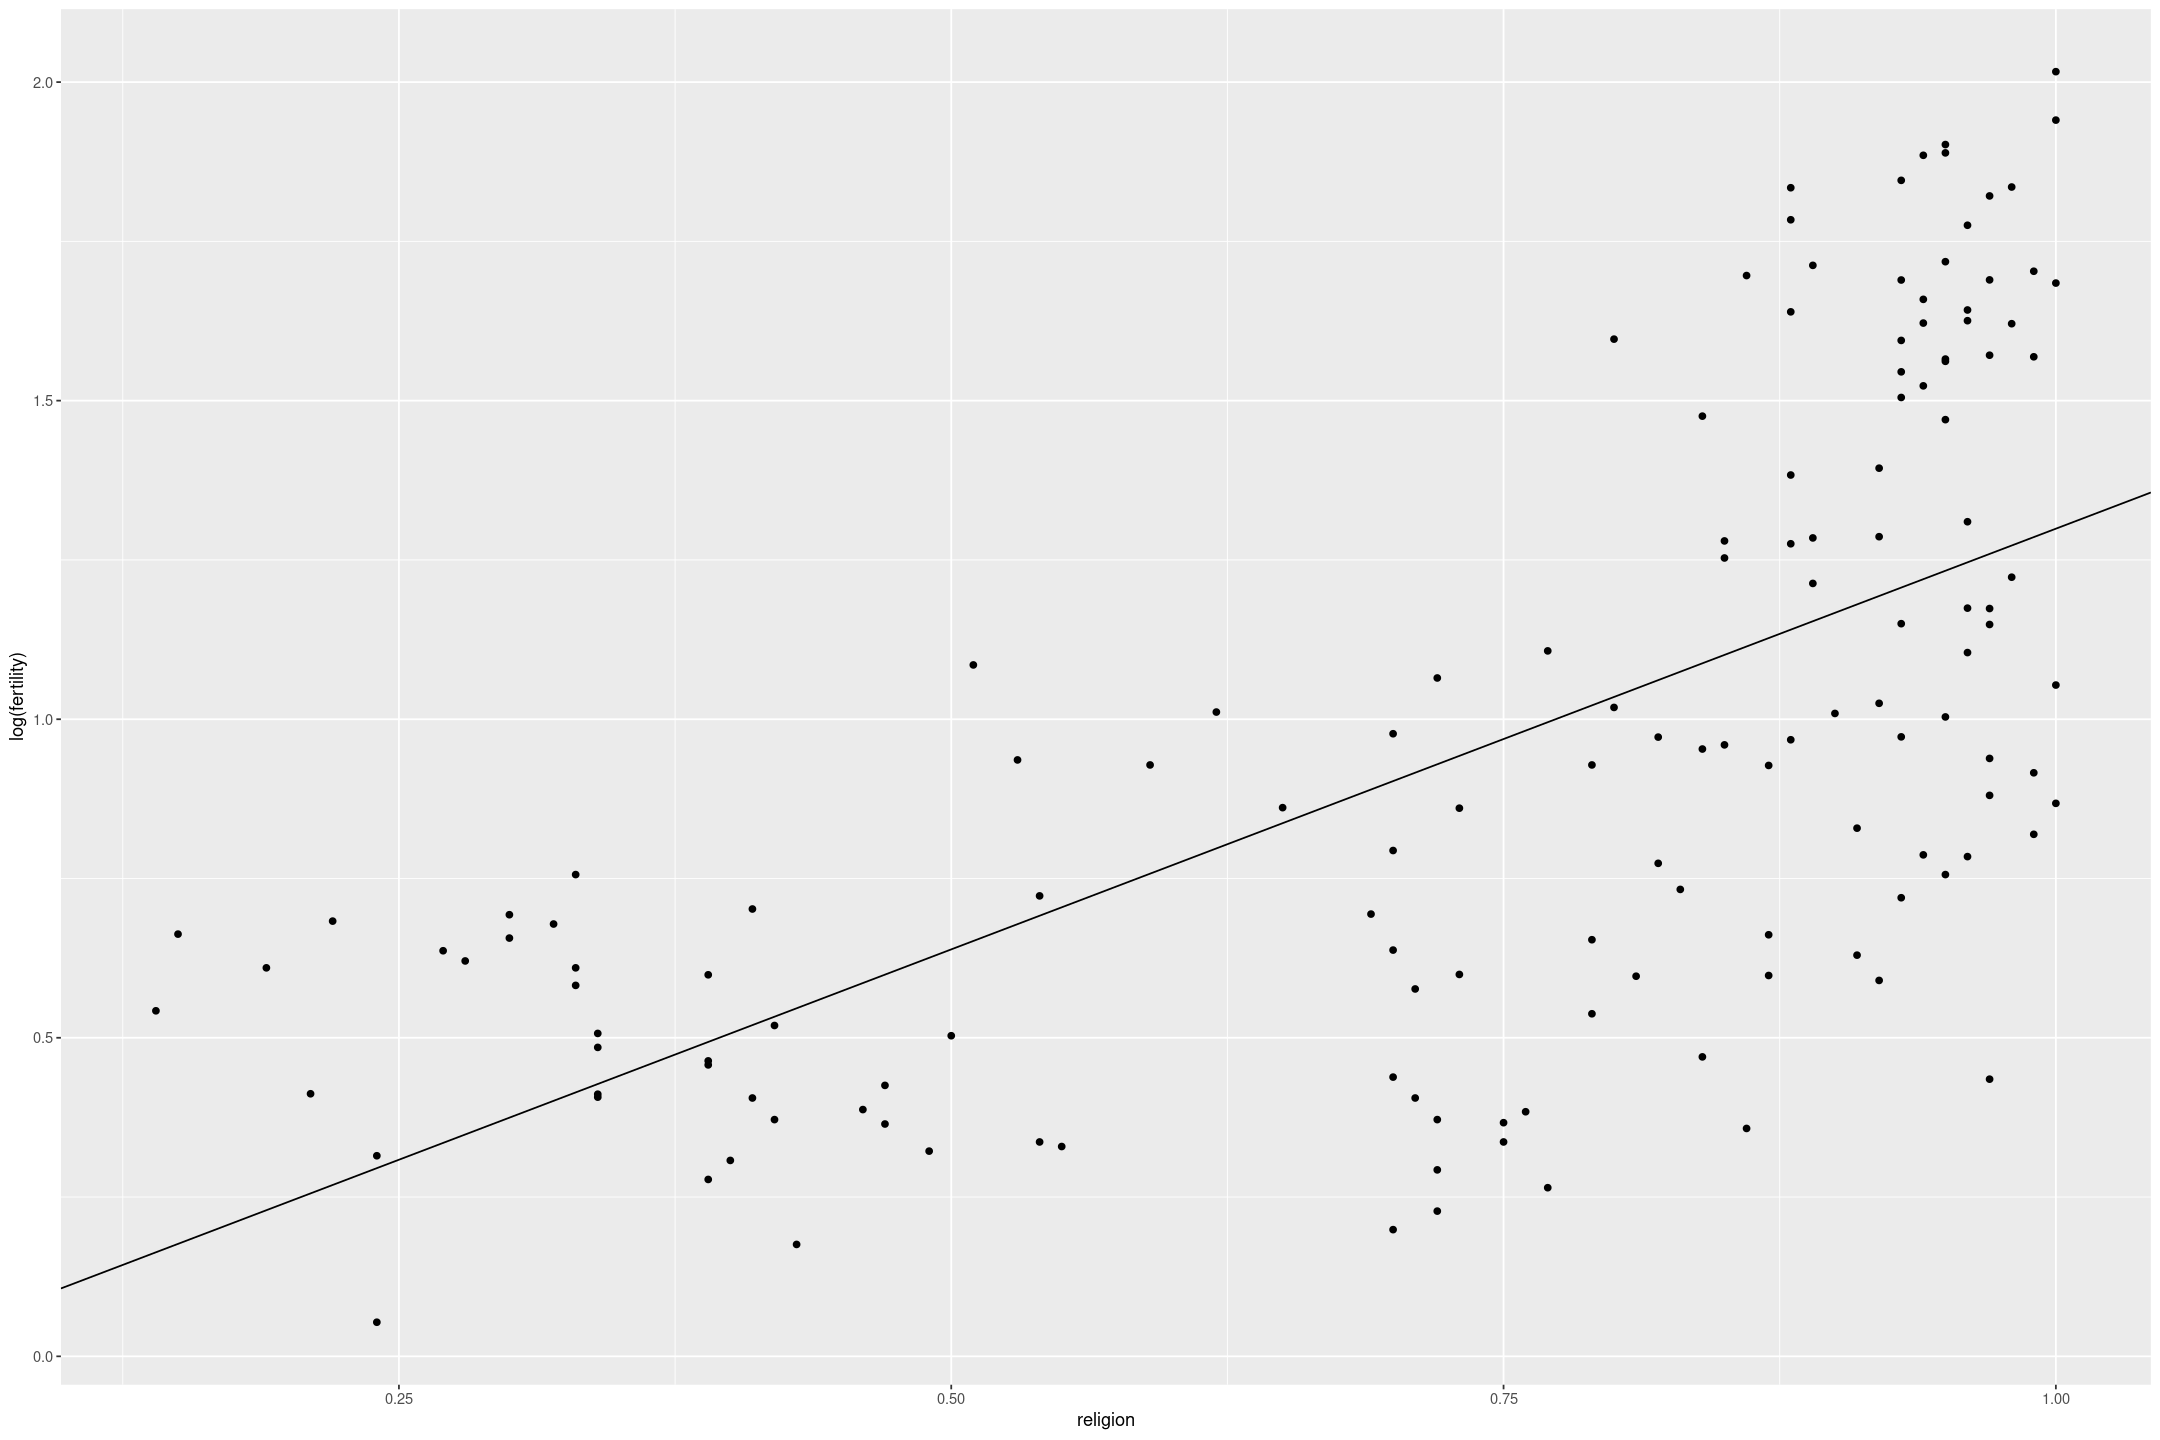

In [256]:
religion_fertility %>% gf_point(log(fertility) ~ religion) + geom_abline(intercept=intercept, slope = slope)

Or translating this into the original scale

In [266]:
fit_line <- data.frame(religion = seq(0, 1, by=0.05)) %>% mutate(fertility = exp(intercept + slope * religion)) 

In [260]:
exp(intercept)

(Intercept) 
  0.9786809

In [262]:
slope

religion 
1.320621

The spread gets much higher at high importance of religion because the scale saturates; at 100% of people saying it's important you can't really distinguish.

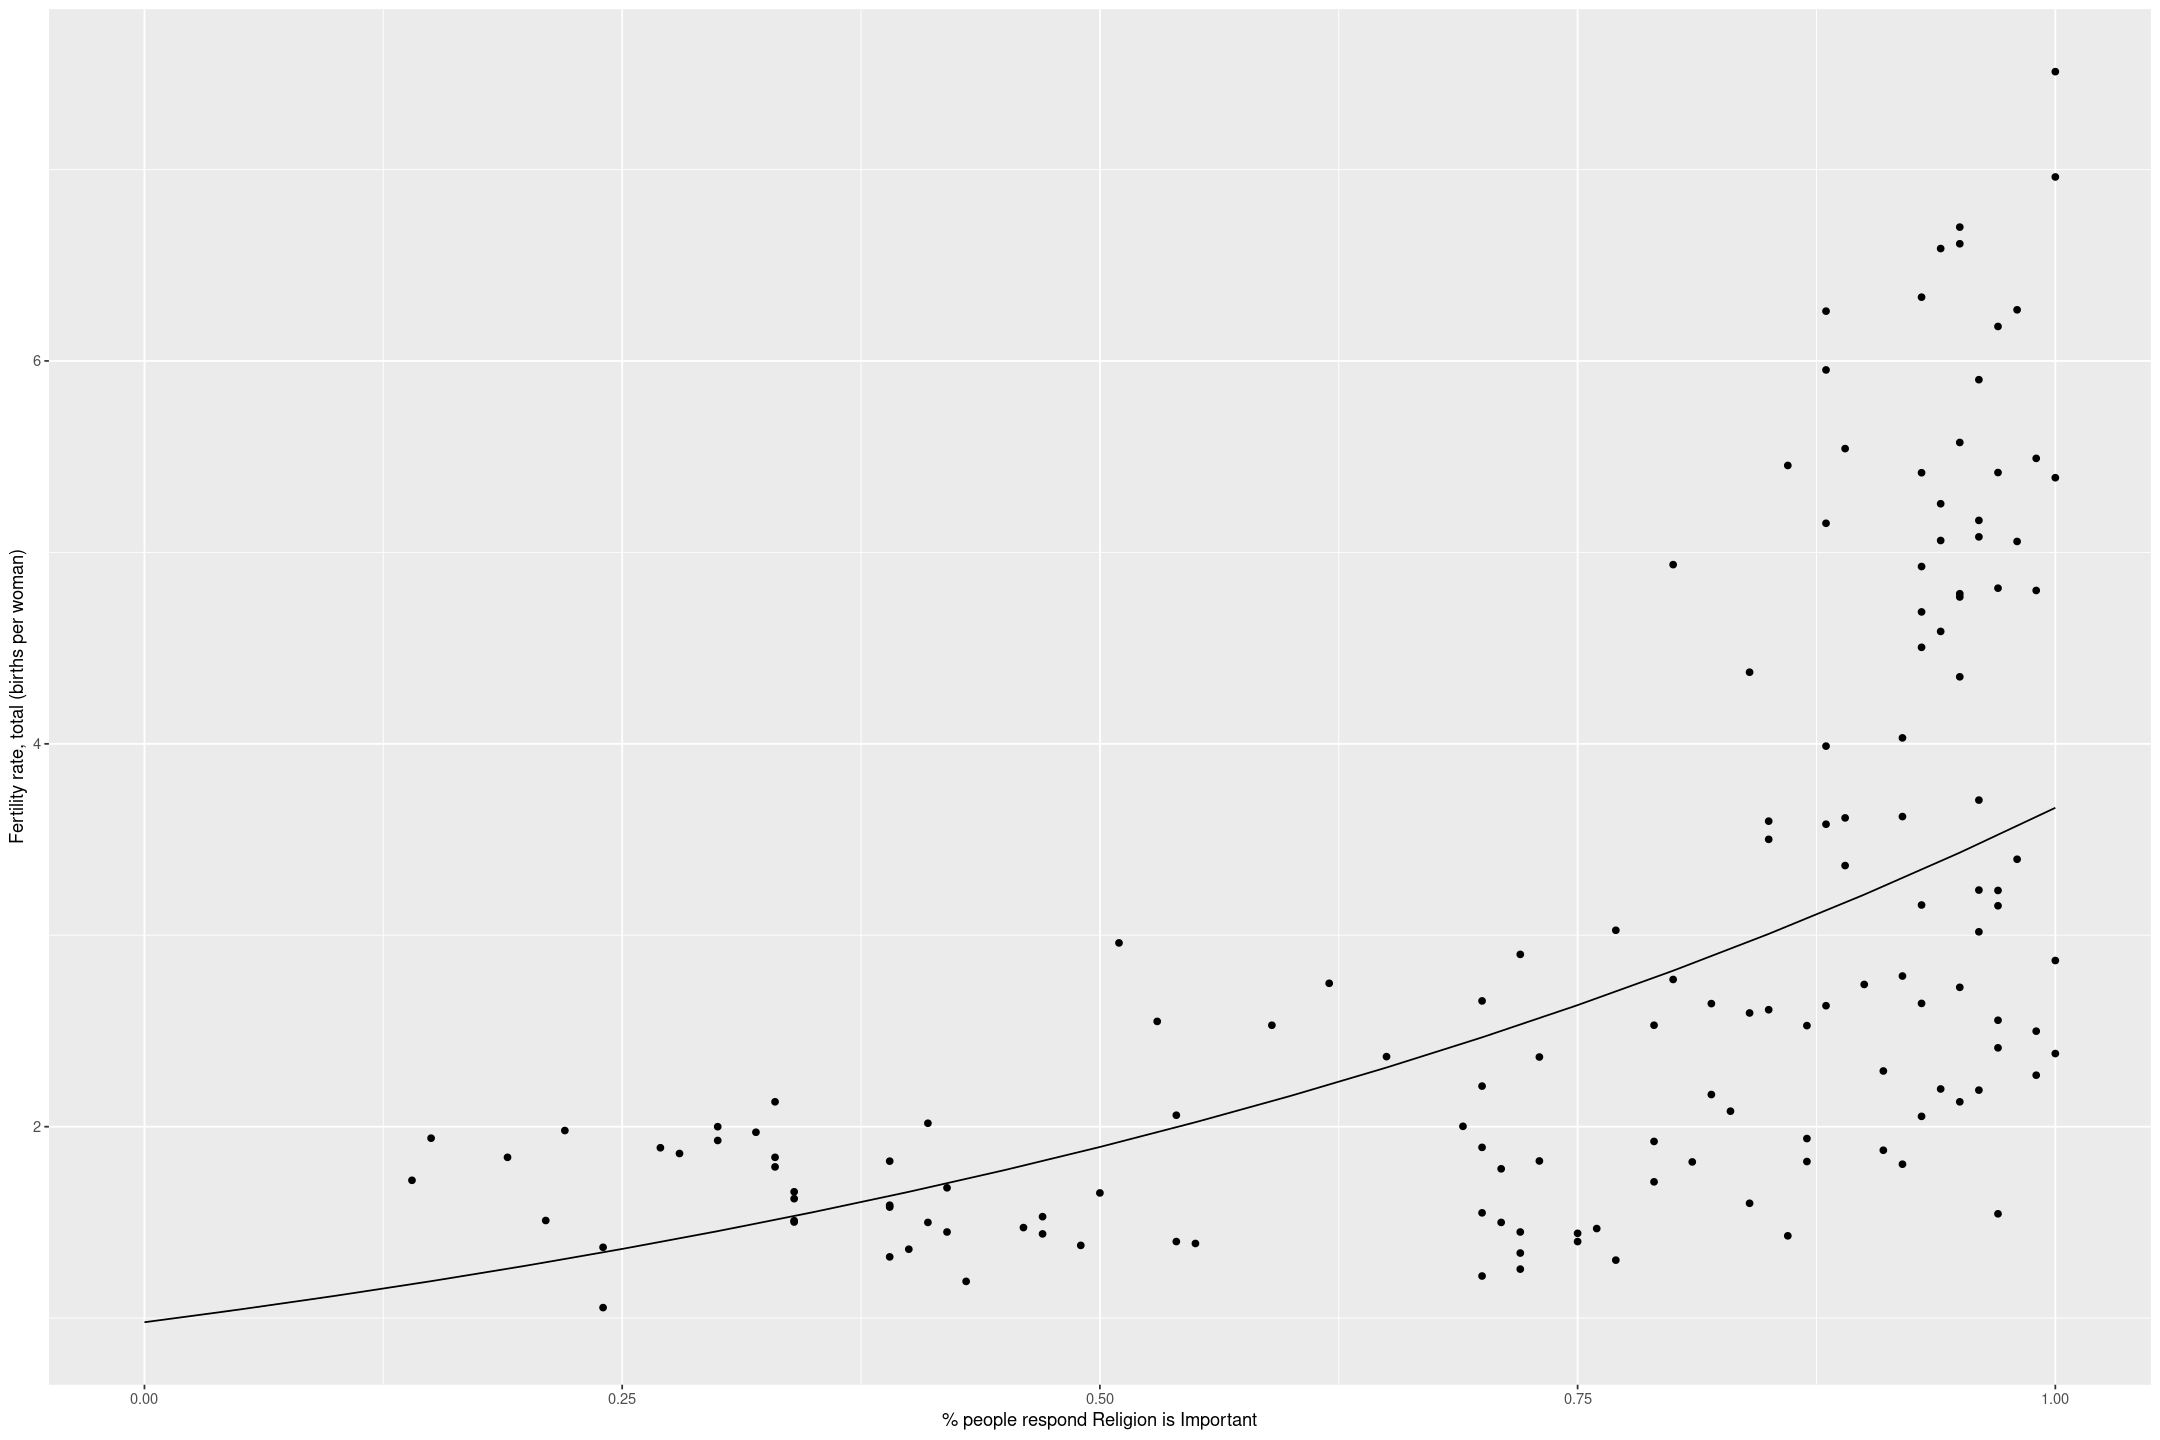

In [267]:
religion_fertility %>% gf_point(fertility ~ religion) %>% gf_line(data=fit_line) + xlab("% people respond Religion is Important")

In [271]:
exp(slope * 0.01)

religion 
1.013294

The model says that 1 percentage point increase in people who say that religion is important in daily life is associated with a 1.3% increase in the fertility rate.

Interesting is the point at which population declines below replacement (neglecting immigration); 2 births per woman.

This is at 54%

In [272]:
(log(2) - intercept) / slope

(Intercept) 
  0.5411824

## Prediction

We can use the missing country of Taiwan as a prediction

In [277]:
importance_religion %>% filter(iso2c == 'TW')

rank,country,yes,no,year,iso2c
<int>,<fct>,<dbl>,<dbl>,<int>,<chr>
30,Taiwan,0.45,0.54,2009,TW


Predicted fertility

In [279]:
pred <- exp(intercept + slope * 0.45)
pred

(Intercept) 
   1.773101

It seems like the [actual number](https://www.macrotrends.net/countries/TWN/taiwan/fertility-rate) in 2009 was 1.06, quite a bit lower.
But it had been undergoing steep decline; 10 years earlier it was 1.69.

The prediction is still within a couple of standard deviations, which is reasonable.

In [286]:
(log(pred) - log(1.06)) / sigma(religion_fertility_model)

(Intercept) 
   1.334351

## Simulating Draws

How well does the model match the data?

In [300]:
N <- 100
sample_x <- runif(N)

sample_y <- exp(intercept + slope * sample_x + rnorm(N, sd=sigma(religion_fertility_model)))

religion_fertility_sample <- data.frame(religion=sample_x, fertility=sample_y)

The sample x distribution isn't right (because I didn't make it right), but the predictions (in red) look similar to the data.

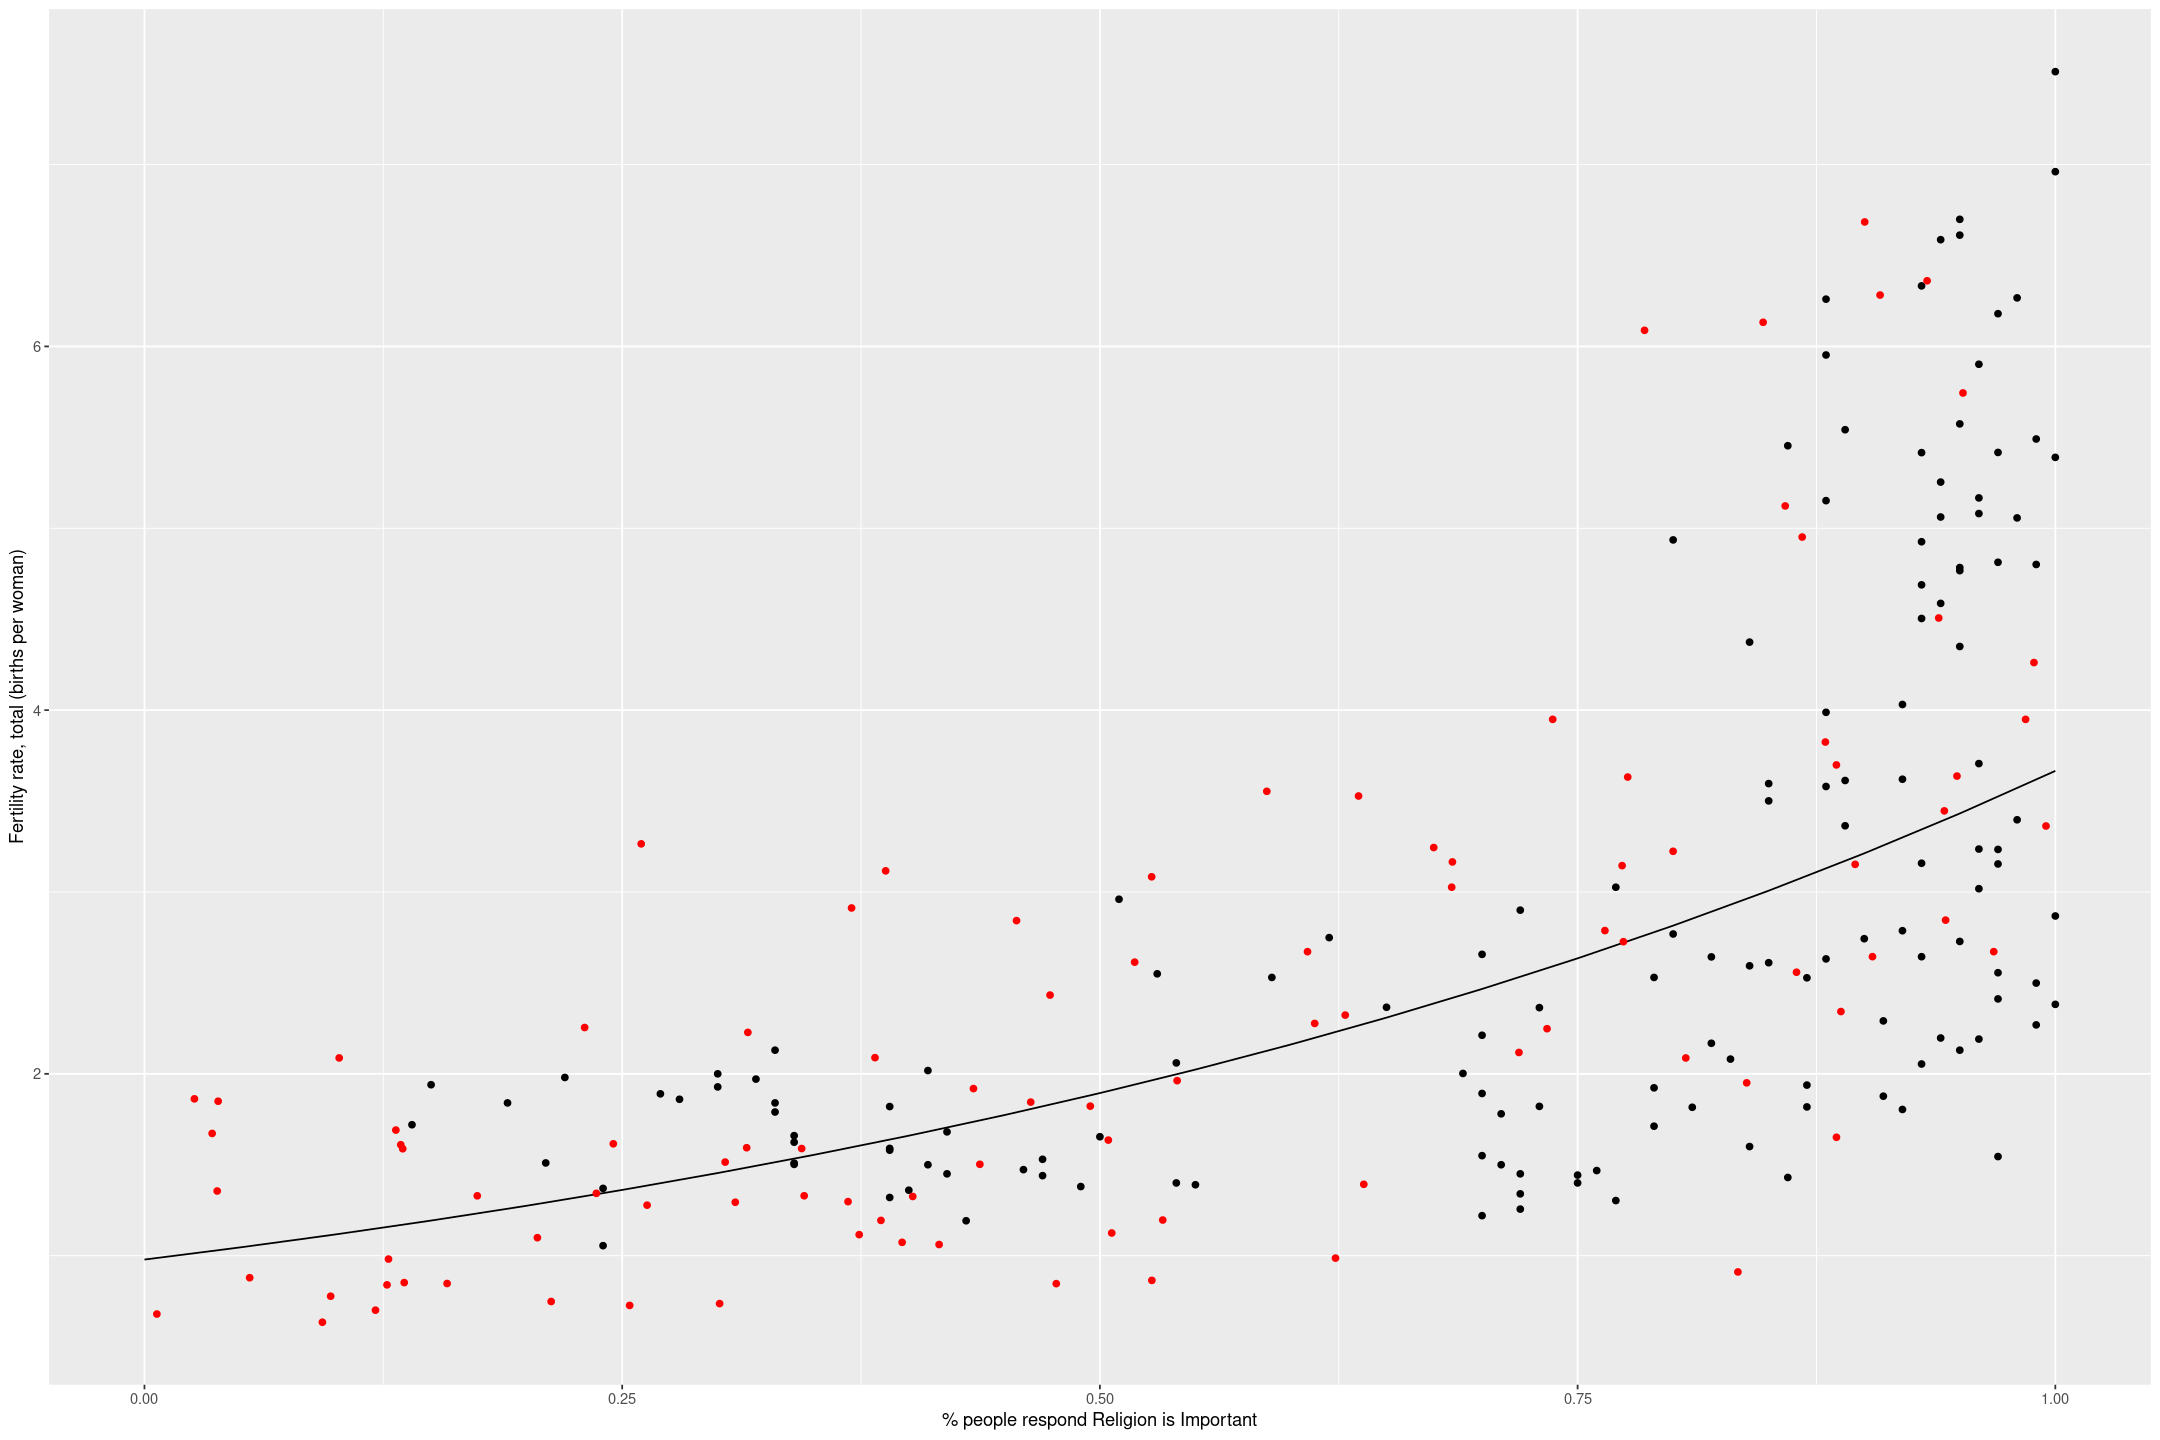

In [302]:
religion_fertility %>% 
gf_point(fertility ~ religion) %>% 
gf_line(data=fit_line) %>%
gf_point(data=religion_fertility_sample, color="red") + 
xlab("% people respond Religion is Important")